In [1]:
from Bio import SeqIO, SeqFeature
import gzip
import pandas as pd
from pycirclize.utils import load_prokaryote_example_file
import numpy as np

filename = load_prokaryote_example_file("escherichia_coli.gbk.gz")
# filename = "C:/Users/dvisi988/Box/Work/genomes and plasmids/genomes/MG1655_features.gb"
with gzip.open(filename, "rt") as handle:
    recs = [rec for rec in SeqIO.parse(handle, "genbank")]

rec = recs[0]

coordinates_file = '240528_localization_data_radial_repInput_normalizedR_polyfit.csv'
coordinates_tbl = pd.read_csv(coordinates_file,sep = ',')
genome_loci = coordinates_tbl.columns[1:]
genome_loci = [int(a.split(sep='_')[0]) for a in genome_loci]
genome_loci = np.unique(genome_loci)
# print(genome_loci)

lib_tbl_file = '220811_lib_tbl.csv'
lib_tbl = pd.read_csv(lib_tbl_file,sep = ',')
pool_tbl_file = '221013_genotyped_strains_sorted.xlsx'
pool_tbl = pd.read_excel(pool_tbl_file,sheet_name='EL4323')
poolStrains = pool_tbl['id'].values
poolStrains = np.append(poolStrains, [21, 70, 90, 89, 23, 33])
#print(lib_tbl.id)
#print(pool_tbl.id)

_, inds, _ = np.intersect1d(lib_tbl['id'].values, poolStrains, return_indices=True)
#print(len(inds))
lib_tbl = lib_tbl.iloc[inds]
#print(lib_tbl)
#genome_loci_pool = lib_tbl['MG1655_ref_genome_location'].values

N_MG1655 = 4641652
oriC_site = 3925860
tmp = np.zeros((2,len(genome_loci)))
tmp[0] = abs(oriC_site-genome_loci)
tmp[1] = genome_loci + (N_MG1655-oriC_site)
distance_to_ori = np.min(tmp, axis=0)


R_tbl = pd.DataFrame()
R_std_tbl = pd.DataFrame()
for g in genome_loci:
    R_tbl[str(g)] = coordinates_tbl[str(g)+'_muR']
    R_std_tbl[str(g)] = coordinates_tbl[str(g)+'_sigmaR']
    
# print(R_tbl)

feature_width = 15e3

for locus in genome_loci:
    start_pos = SeqFeature.ExactPosition(locus-feature_width/2)
    end_pos = SeqFeature.ExactPosition(locus+feature_width/2)
    feature_location = SeqFeature.FeatureLocation(start_pos,end_pos)
    feature_type = "lib_site"
    feature = SeqFeature.SeqFeature(feature_location,type=feature_type)
    rec.features.append(feature)
    
for i, locus in lib_tbl.iterrows():
    #print(locus)
    start_pos = SeqFeature.ExactPosition(locus['MG1655_ref_genome_location']-feature_width/2)
    end_pos = SeqFeature.ExactPosition(locus['MG1655_ref_genome_location']+feature_width/2)
    feature_location = SeqFeature.FeatureLocation(start_pos,end_pos)
    feature_type = 'lib_' + locus['type']
    feature = SeqFeature.SeqFeature(feature_location,type=feature_type)
    rec.features.append(feature)
    

oriMD = [3759738, 4641652]
start_pos = SeqFeature.ExactPosition(3759738)
end_pos = SeqFeature.ExactPosition(4641652)
feature_location = SeqFeature.FeatureLocation(start_pos,end_pos)
feature_type = "Ori_MD"
feature = SeqFeature.SeqFeature(feature_location,type=feature_type)
rec.features.append(feature)

rightMD = [603414, 1206829]
start_pos = SeqFeature.ExactPosition(603414)
end_pos = SeqFeature.ExactPosition(1206829)
feature_location = SeqFeature.FeatureLocation(start_pos,end_pos)
feature_type = "Right_MD"
feature = SeqFeature.SeqFeature(feature_location,type=feature_type)
rec.features.append(feature)

#terMD = [1206829+1, 2181576]
terMD = [1206829+1, 2042326]
start_pos = SeqFeature.ExactPosition(1206829+1)
#end_pos = SeqFeature.ExactPosition(2181576)
end_pos = SeqFeature.ExactPosition(2042326)
feature_location = SeqFeature.FeatureLocation(start_pos,end_pos)
feature_type = "Terminus_MD"
feature = SeqFeature.SeqFeature(feature_location,type=feature_type)
rec.features.append(feature)

#leftMD = [2181576+1, 2877824]
leftMD = [2042326+1, 2877824]
#start_pos = SeqFeature.ExactPosition(2181576+1)
start_pos = SeqFeature.ExactPosition(2042326+1)
end_pos = SeqFeature.ExactPosition(2877824)
feature_location = SeqFeature.FeatureLocation(start_pos,end_pos)
feature_type = "Left_MD"
feature = SeqFeature.SeqFeature(feature_location,type=feature_type)
rec.features.append(feature)

SeqIO.write(rec, "MG1655_libAnnotated.gbk", "genbank")


1

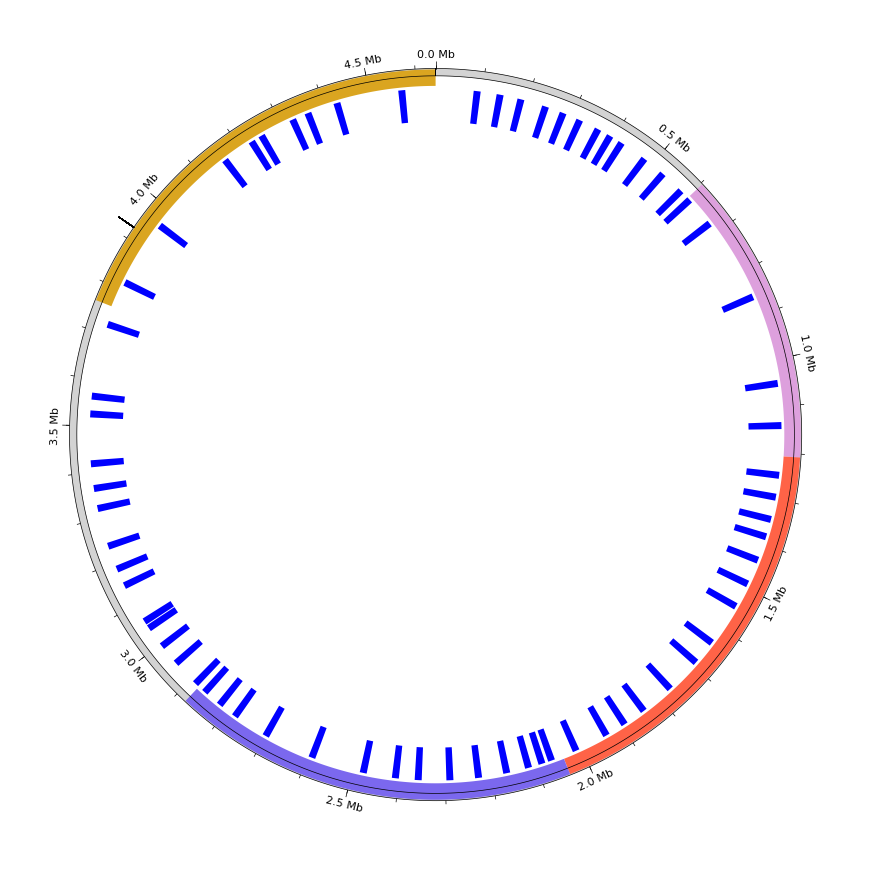

In [2]:
from pycirclize import Circos
from pycirclize.parser import Genbank
from pycirclize.utils import load_prokaryote_example_file
import numpy as np
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Load Genbank file
# gbk_file = load_prokaryote_example_file("escherichia_coli.gbk.gz")
gbk_file = "MG1655_libAnnotated.gbk"
gbk = Genbank(gbk_file)
#print(gbk_file)

circos = Circos(sectors={gbk.name: gbk.range_size})
#circos.text("Escherichia coli\n(NC_000913)", size=12, r=20)
sector = circos.get_sector(gbk.name)

# Plot outer track with xticks
major_ticks_interval = 500000
minor_ticks_interval = 100000
outer_track = sector.add_track((98, 100))
outer_track.axis(fc="lightgrey")
outer_track.xticks_by_interval(
    major_ticks_interval, label_formatter=lambda v: f"{v/ 10 ** 6:.1f} Mb"
)
outer_track.xticks_by_interval(minor_ticks_interval, tick_length=1, show_label=False)

ori = gbk.extract_features("rep_origin")
#print(type(ori[0].location))
outer_track.xticks(ori[0].location,tick_length=5)

MD_track = sector.add_track((95, 100), r_pad_ratio=0.1)
MD_track.genomic_features(gbk.extract_features("Ori_MD"), fc="goldenrod")
MD_track.genomic_features(gbk.extract_features("Right_MD", target_strand=1), fc="plum")
MD_track.genomic_features(gbk.extract_features("Terminus_MD", target_strand=1), fc="tomato")
MD_track.genomic_features(gbk.extract_features("Left_MD", target_strand=1), fc="mediumslateblue")

libSites_track = sector.add_track((85, 95), r_pad_ratio=0.1)
libSites_track.genomic_features(gbk.extract_features("lib_site"), fc="blue")



#oriC_track = sector.add_track((90, 100), r_pad_ratio=0.01)
#oriC_track.genomic_features(gbk.extract_features("rep_origin", target_strand=1), fc="black")

fig = circos.plotfig()
fig.savefig('Fig2-EL4323_sites.png')
fig.savefig('Fig2-EL4323_sites.pdf')

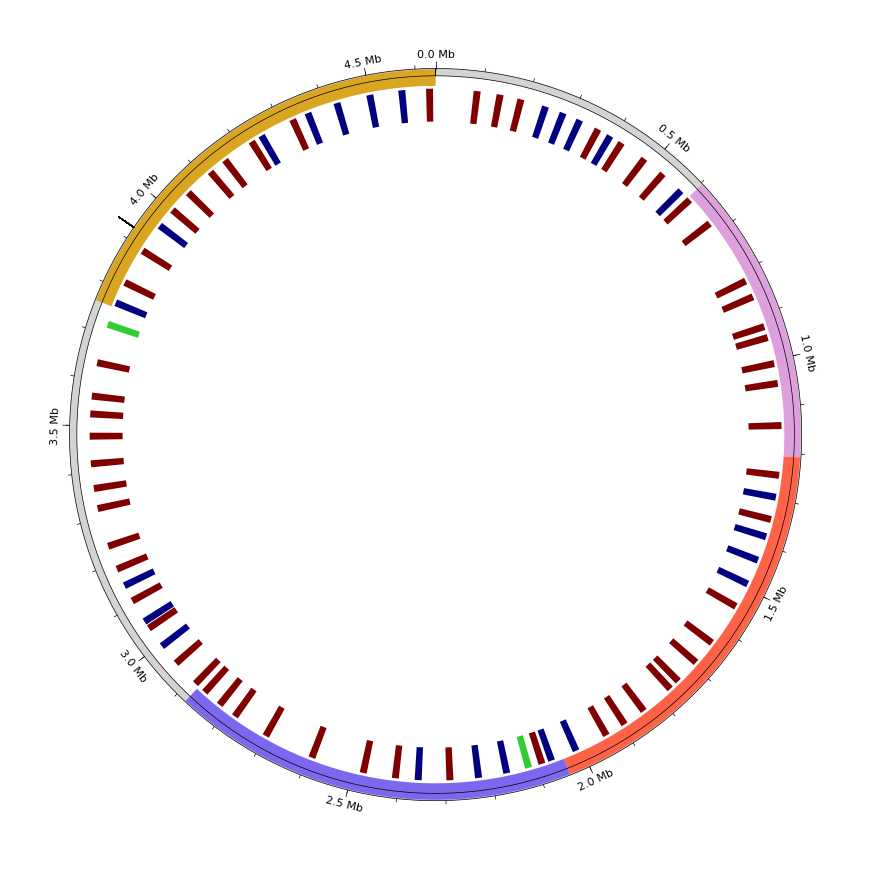

In [3]:
from pycirclize import Circos
from pycirclize.parser import Genbank
from pycirclize.utils import load_prokaryote_example_file
import numpy as np
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Load Genbank file
# gbk_file = load_prokaryote_example_file("escherichia_coli.gbk.gz")
gbk_file = "MG1655_libAnnotated.gbk"
gbk = Genbank(gbk_file)
#print(gbk_file)

circos = Circos(sectors={gbk.name: gbk.range_size})
#circos.text("Escherichia coli\n(NC_000913)", size=12, r=20)
sector = circos.get_sector(gbk.name)

# Plot outer track with xticks
major_ticks_interval = 500000
minor_ticks_interval = 100000
outer_track = sector.add_track((98, 100))
outer_track.axis(fc="lightgrey")
outer_track.xticks_by_interval(
    major_ticks_interval, label_formatter=lambda v: f"{v/ 10 ** 6:.1f} Mb"
)
outer_track.xticks_by_interval(minor_ticks_interval, tick_length=1, show_label=False)

ori = gbk.extract_features("rep_origin")
#print(type(ori[0].location))
outer_track.xticks(ori[0].location,tick_length=5)

MD_track = sector.add_track((95, 100), r_pad_ratio=0.1)
MD_track.genomic_features(gbk.extract_features("Ori_MD"), fc="goldenrod")
MD_track.genomic_features(gbk.extract_features("Right_MD", target_strand=1), fc="plum")
MD_track.genomic_features(gbk.extract_features("Terminus_MD", target_strand=1), fc="tomato")
MD_track.genomic_features(gbk.extract_features("Left_MD", target_strand=1), fc="mediumslateblue")

libSites_track = sector.add_track((85, 95), r_pad_ratio=0.1)
libSites_track.genomic_features(gbk.extract_features("lib_pseudo"), fc="navy")
libSites_track.genomic_features(gbk.extract_features("lib_intergenic"), fc="maroon")
libSites_track.genomic_features(gbk.extract_features("lib_CDS"), fc="limegreen")



#oriC_track = sector.add_track((90, 100), r_pad_ratio=0.01)
#oriC_track.genomic_features(gbk.extract_features("rep_origin", target_strand=1), fc="black")

fig = circos.plotfig()
fig.savefig('Fig1a-EL4323_sites_annotated.png')
fig.savefig('Fig1a-EL4323_sites_annotated.pdf')



In [4]:
print(sum(lib_tbl['type']=='pseudo'))
print(sum(lib_tbl['type']=='intergenic'))
print(sum(lib_tbl['type']=='CDS'))

24
57
2


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Ori vs. NSR: t-test independent samples, P_val:2.970e-02 t=-2.351e+00
Right vs. Terminus: t-test independent samples, P_val:1.383e-03 t=3.816e+00
Left vs. NSL: t-test independent samples, P_val:3.888e-03 t=3.169e+00
Ori vs. Right: t-test independent samples, P_val:7.124e-04 t=-4.511e+00
Right vs. NSL: t-test independent samples, P_val:1.269e-03 t=3.855e+00
NSR vs. NSL: t-test independent samples, P_val:1.493e-02 t=2.622e+00
Ori vs. Left: t-test independent samples, P_val:1.244e-02 t=-2.734e+00
         MD1       MD2  T-Statistic   P-Value significant
0        NSR     Right    -1.366772  0.191834           0
1        NSR  Terminus     2.228445  0.035477           1
2        NSR      Left    -0.654761  0.518848           0
3        NSR       NSL     2.622456  0.014926           1
4        NSR       

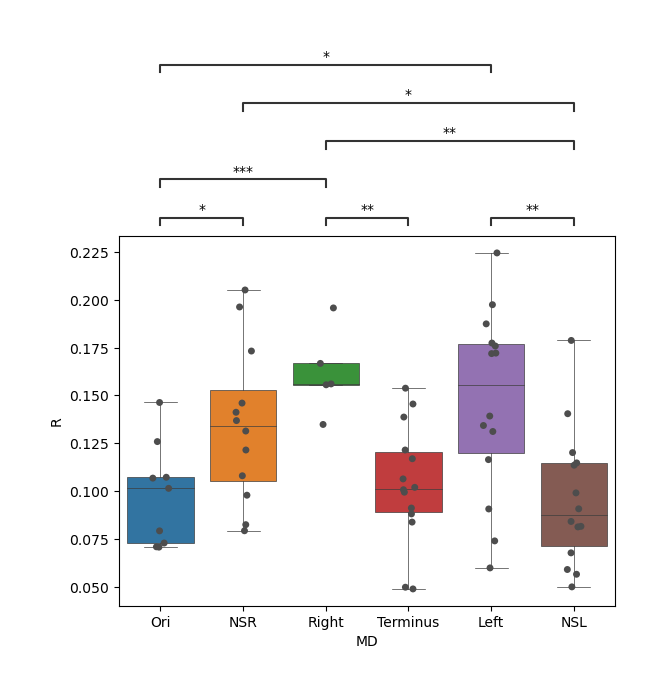

In [9]:
import seaborn as sns
import scipy.stats as stats
import itertools
import warnings
#import statannot
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

warnings.filterwarnings("ignore")

Rdf = pd.DataFrame({'R': y, 'genomic_loci': x, 'MD': 'a'})
for i, row in Rdf.iterrows():
    if row.genomic_loci >= oriMD[0] and row.genomic_loci <= oriMD[1]:
        Rdf.MD[i] = 'Ori'
    elif row.genomic_loci > 0 and row.genomic_loci < rightMD[0]:
        Rdf.MD[i] = 'NSR'
    elif row.genomic_loci >= rightMD[0] and row.genomic_loci <= rightMD[1]:
        Rdf.MD[i] = 'Right'
    elif row.genomic_loci >= terMD[0] and row.genomic_loci <= terMD[1]:
        Rdf.MD[i] = 'Terminus'
    elif row.genomic_loci >= leftMD[0] and row.genomic_loci <= leftMD[1]:
        Rdf.MD[i] = 'Left'
    elif row.genomic_loci > leftMD[1] and row.genomic_loci < oriMD[0]:
        Rdf.MD[i] = 'NSL'

fig, ax = plt.subplots(1, 1)
order = ['Ori', 'NSR', 'Right', 'Terminus', 'Left', 'NSL']
sns.boxplot(x='MD', y='R', data=Rdf, fliersize=0, order=order )
alpha=0.3
sns.stripplot( x='MD', y='R', data=Rdf, color=np.array([0,0,0])+alpha, order=order )
pairs=[("NSR", "NSL"), ("NSR", "Ori"), ("Right",  "Terminus"), ("Right", "NSL"), 
       ("Right", "Ori"), ("Left", "Ori"), ("Left", "NSL")]
#pairs = [("Right", "NSL"), ("Right", "Ori")]

annotator = Annotator(ax, pairs, data=Rdf, x='MD', y='R', order=order)
annotator.configure(test='t-test_ind', text_format='star', loc='outside', comparisons_correction=None)
annotator.apply_and_annotate()

MDs = Rdf['MD'].unique()
results = pd.DataFrame(columns=['MD1', 'MD2', 'T-Statistic', 'P-Value', 'significant'])
alpha = 0.05
for MD1, MD2 in itertools.combinations(MDs, 2):
        # Subset the data for the two categories
        group1 = Rdf[Rdf['MD'] == MD1]['R']
        group2 = Rdf[Rdf['MD'] == MD2]['R']

        # Perform Welch's t-test
        t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=True)
        s = 0
        if p_value<alpha:
            s = 1

        # Store the result
        results = results.append({'MD1': MD1, 'MD2': MD2, 
                                  'T-Statistic': t_stat, 'P-Value': p_value, 'significant': s}, 
                                 ignore_index=True)
        
print(results)


#statannot.add_stat_annotation(
#    ax,
#    data=Rdf,
#    x='R',
#    y='MD',
#    #box_pairs=[("NSR", "NSL"), ("NSR", "Ori"), ("Right",  "Terminus"), ("Right", "NSL"), ("Right", "Ori"), ("Left", "Ori"), ("Left", "NSL") ],
#    box_pairs=[("Right", "NSL"), ("Right", "Ori")],
#    test="t-test_ind",
#    text_format="star",
#    loc="outside",
#)
print(Rdf)
warnings.filterwarnings("default")


MOC	 right domain = 0.652693;	 left domain = 0.725388
Jaccard index	 right domain = 0.652693;	 left domain = 0.740049
Overlap coefficient	 right domain = 1.000000;	 left domain = 0.895913
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: t-test independent samples, P_val:8.158e-10 t=-7.167e+00


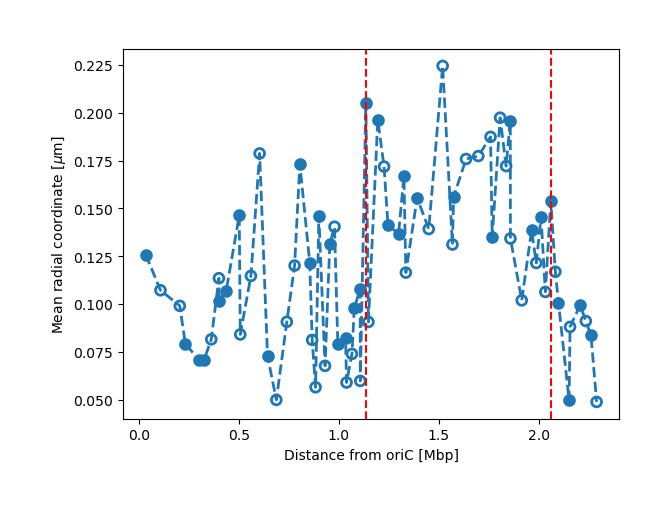

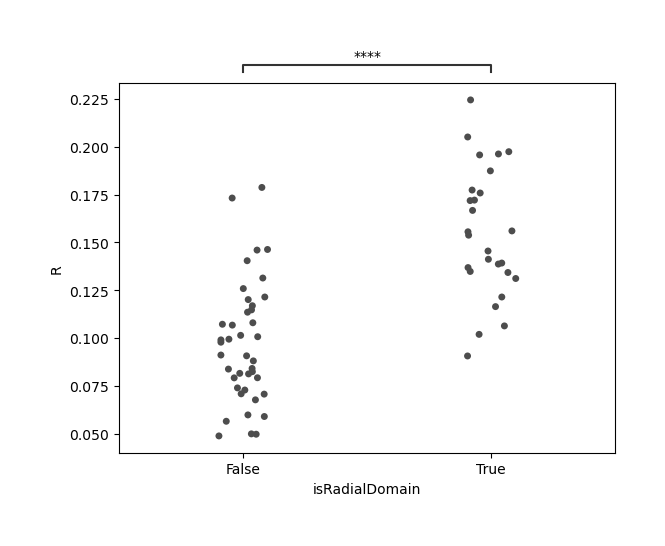

In [56]:
from matplotlib.ticker import ScalarFormatter
from copy import deepcopy

#fig, ax = plt.subplots(1, 1)
#plt.plot(x,y)
#xnew = np.linspace(0,N_MG1655,1000)
#ynew = np.interp(xnew, x, y)
#plt.plot(xnew, ynew)

N_MG1655 = 4641652
oriC_site = 3925860

warnings.filterwarnings("ignore")
x = genome_loci
y = R_tbl.mean(axis=0).values
genome_half = deepcopy(genome_loci)
genome_half[np.logical_and(genome_half>(oriC_site-N_MG1655/2),genome_half<oriC_site)] = -1
genome_half[genome_half>0] = 1
#print(genome_half)

inds = np.argsort(distance_to_ori)
y_sorted = y[inds]
genome_half_sorted = genome_half[inds]
distance_to_ori_sorted = np.sort(distance_to_ori)
fig, ax = plt.subplots(1, 1)
plt.plot(distance_to_ori_sorted/1e6, y_sorted,'--',linewidth=2)
plt.scatter(distance_to_ori_sorted[genome_half_sorted==-1]/1e6, y_sorted[genome_half_sorted==-1],edgecolors='#1f77b4', facecolors='none', s=50, linewidths=2)
plt.scatter(distance_to_ori_sorted[genome_half_sorted==1]/1e6, y_sorted[genome_half_sorted==1],edgecolors='#1f77b4', facecolors='#1f77b4', s=50, linewidths=2)
#plt.plot(distance_to_ori_sorted[genome_half_sorted==-1]/1e6, y_sorted[genome_half_sorted==-1],'.b',linewidth=2,markersize=10)
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=False))
plt.ticklabel_format(style='plain', axis='x')
plt.xlabel('Distance from oriC [Mbp]')
plt.ylabel(r'Mean radial coordinate [$\mu$m]')

#print(distance_to_ori_sorted[np.argwhere(y_sorted>0.19)])
#print('')
#print(distance_to_ori_sorted[np.argwhere(y_sorted>0.15)])
#
radialDomain = [1135000, 2059500]
radialDomainRight = [radialDomain[0]-(N_MG1655-oriC_site), radialDomain[1]-(N_MG1655-oriC_site)]
radialDomainLeft = [oriC_site-radialDomain[1], oriC_site-radialDomain[0]]

overlapRight = min([radialDomainRight[1], rightMD[1]])-max([radialDomainRight[0], rightMD[0]])
unionRight = max([radialDomainRight[1], rightMD[1]])-min([radialDomainRight[0], rightMD[0]])
mocRight = overlapRight**2/((radialDomainRight[1]-radialDomainRight[0])*(rightMD[1]-rightMD[0]))
jaccardRight = overlapRight/unionRight
overlapCoefRight = overlapRight/min([(radialDomainRight[1]-radialDomainRight[0]),(rightMD[1]-rightMD[0])])
overlapLeft = min([radialDomainLeft[1], leftMD[1]])-max([radialDomainLeft[0], leftMD[0]])
unionLeft = max([radialDomainLeft[1], leftMD[1]])-min([radialDomainLeft[0], leftMD[0]])
mocLeft = overlapLeft**2/((radialDomainLeft[1]-radialDomainLeft[0])*(leftMD[1]-leftMD[0]))
jaccardLeft = overlapLeft/unionLeft
overlapCoefLeft = overlapLeft/min([(radialDomainLeft[1]-radialDomainLeft[0]),(leftMD[1]-leftMD[0])])
print("MOC\t right domain = %f;\t left domain = %f" % (mocRight, mocLeft))
print("Jaccard index\t right domain = %f;\t left domain = %f" % (jaccardRight, jaccardLeft))
print("Overlap coefficient\t right domain = %f;\t left domain = %f" % (overlapCoefRight, overlapCoefLeft))

ax.axvline(x=radialDomain[0]/1e6,linestyle='--',linewidth=1.5,color='r')
ax.axvline(x=radialDomain[1]/1e6,linestyle='--',linewidth=1.5,color='r')

fig.savefig('Fig4b-radialDomain.pdf')

Rdf['distance_from_oriC'] = distance_to_ori
Rdf['isRadialDomain'] = False
for i, row in Rdf.iterrows():
    Rdf.loc[i,'isRadialDomain'] = row.distance_from_oriC>radialDomain[0] and row.distance_from_oriC<radialDomain[1]
        

fig, ax = plt.subplots(1, 1)
#sns.boxplot(x='isRadialDomain', y='R', data=Rdf, fliersize=0 )
alpha=0.3
sns.stripplot( x='isRadialDomain', y='R', data=Rdf, color=np.array([0,0,0])+alpha)
#sns.stripplot( x='isRadialDomain', y='R', data=Rdf, color='blue')
#for i, row in Rdf.iterrows():
pairs=[(False, True)]
#pairs = [("Right", "NSL"), ("Right", "Ori")]

annotator = Annotator(ax, pairs, data=Rdf, x='isRadialDomain', y='R')
annotator.configure(test='t-test_ind', text_format='star', loc='outside')
annotator.apply_and_annotate()
warnings.filterwarnings("default")

[20, 21, 22, 23, 24, 25, 26, 27]
['1.2', '1.3', '1.3', '1.3', '1.4', '1.4', '1.4', '1.5', '1.5', '1.6', '1.6', '1.6', '1.7', '1.7', '1.7', '1.8', '1.8', '1.9', '1.9', '1.9', '2.0', '2.0', '2.1', '2.1', '2.1', '2.2', '2.2', '2.2', '2.3', '2.3']


C:\Users\dvisi988\Anaconda3\lib\site-packages\seaborn\categorical.py:71: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data[col].astype(np.float)
C:\Users\dvisi988\Anaconda3\lib\site-packages\seaborn\categorical.py:81: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, np.float) for k, s in iter_data]
C:\Users\dvisi988\Anaconda3\lib\site-packages\seaborn\categorical.py:81: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy 

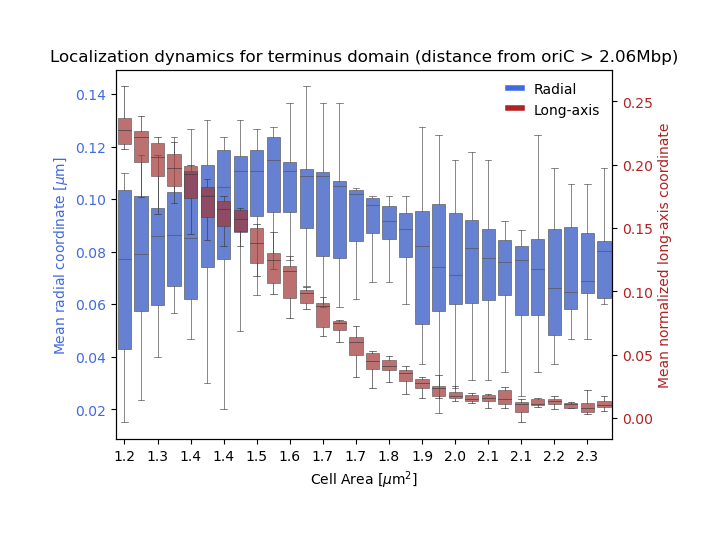

In [49]:
from copy import deepcopy
import matplotlib.pyplot as plt

inds = np.argwhere(distance_to_ori > radialDomain[1])
#inds = np.argwhere(distance_to_ori > 2100000)
inds = list(map(lambda x: x[0], inds))
print(inds)
terR = R_tbl.iloc[:,list(inds)]
M0 = pd.read_excel('M00.xlsx')
#terR['cellArea'] = M0['cellArea']
terR = terR.T
#terR.rename(columns = str(M0['cellArea']) )
#print(terR)
areaTicklabel = []
for a in M0['cellArea'].values:
    areaTicklabel.append('%1.1f' % a)
print(areaTicklabel)
fig, ax1 = plt.subplots(1, 1)
sns.boxplot(ax=ax1, data=terR,color='royalblue',fliersize=0, boxprops=dict(alpha=.9))
ax1.set_xticks(np.arange(0,29,2))
ax1.set_xticklabels(areaTicklabel[::2])
ax1.set_xlabel(r'Cell Area [$\mu$m$^2$]')
ax1.set_ylabel(r'Mean radial coordinate [$\mu$m]', color='royalblue')
ax1.tick_params(axis='y', labelcolor='royalblue')
#ax1.set_title('Radial localization dynamics for terminus domain (distance from oriC > 2.06Mbp)')

x_tbl = deepcopy(coordinates_tbl)
x_tbl = x_tbl.filter(regex='mu')
#print(x_tbl)
for g in genome_loci:
    x_tbl.drop(str(g)+'_muR',axis=1,inplace=True)
    x_tbl.drop(str(g)+'_mu3',axis=1,inplace=True)
    x_tbl.drop(str(g)+'_mu4',axis=1,inplace=True)
    tmp = np.zeros((len(x_tbl),2))
    tmp[:,0] = x_tbl[str(g)+'_mu1'].values
    tmp[:,1] = x_tbl[str(g)+'_mu2'].values
    x_tbl[str(g)+'_mu'] = np.nanmean(tmp,axis=1)
    x_tbl.drop(str(g)+'_mu1',axis=1,inplace=True)
    x_tbl.drop(str(g)+'_mu2',axis=1,inplace=True)

#print(x_tbl)
terX =   x_tbl.iloc[:,list(inds)]
terX = terX.T
#print(terX)
#fig, ax2 = plt.subplots(1, 1)
ax2 = ax1.twinx()
sns.boxplot(ax=ax2, data=terX,color='firebrick',fliersize=0, boxprops=dict(alpha=.7))
ax2.set_xticks(np.arange(0,29,2))
ax2.set_xticklabels(areaTicklabel[::2])
ax2.set_xlabel(r'Cell Area [$\mu$m$^2$]')
ax2.set_ylabel('Mean normalized long-axis coordinate', color='firebrick')
ax2.tick_params(axis='y', labelcolor='firebrick')
ax2.set_title('Localization dynamics for terminus domain (distance from oriC > 2.06Mbp)')

custom_lines = [plt.Line2D([0], [0], color='royalblue', lw=4),
                plt.Line2D([0], [0], color='firebrick', lw=4)]
ax1.legend(custom_lines, ['Radial', 'Long-axis'], loc='upper right')

fig.savefig('Fig4c-terminusDynamics.png')
fig.savefig('Fig4c-terminusDynamics.pdf')

0.245463183084551


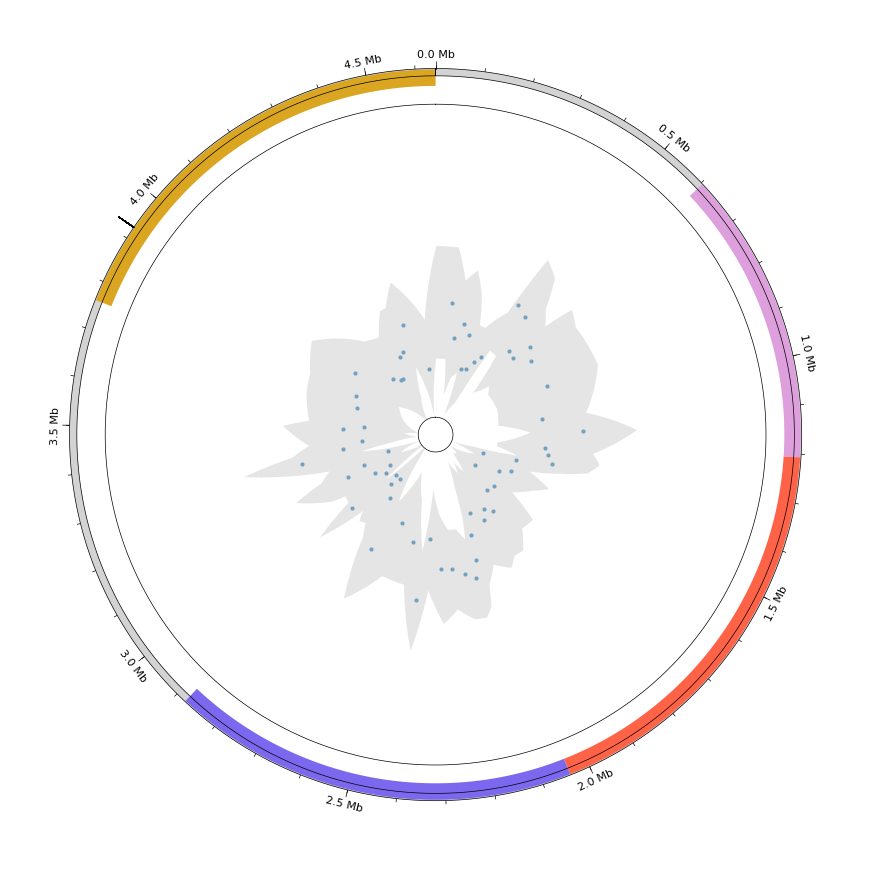

In [12]:

N_MG1655 = 4641652

circos = Circos(sectors={gbk.name: gbk.range_size})
#circos.text("Escherichia coli\n(NC_000913)", size=12, r=20)
sector = circos.get_sector(gbk.name)

# Plot outer track with xticks
major_ticks_interval = 500000
minor_ticks_interval = 100000
outer_track = sector.add_track((98, 100))
outer_track.axis(fc="lightgrey")
outer_track.xticks_by_interval(
    major_ticks_interval, label_formatter=lambda v: f"{v/ 10 ** 6:.1f} Mb"
)
outer_track.xticks_by_interval(minor_ticks_interval, tick_length=1, show_label=False)

ori = gbk.extract_features("rep_origin")
outer_track.xticks(ori[0].location,tick_length=5)

MD_track = sector.add_track((95, 100), r_pad_ratio=0.1)
MD_track.genomic_features(gbk.extract_features("Ori_MD"), fc="goldenrod")
MD_track.genomic_features(gbk.extract_features("Right_MD", target_strand=1), fc="plum")
MD_track.genomic_features(gbk.extract_features("Terminus_MD", target_strand=1), fc="tomato")
MD_track.genomic_features(gbk.extract_features("Left_MD", target_strand=1), fc="mediumslateblue")

cellRadius = 0.47

R_track = sector.add_track((0, 95), r_pad_ratio=0.1)
x = genome_loci
y = R_tbl.mean(axis=0).values
R_track.scatter(x,y,vmin=0, vmax=cellRadius)
R_track.line([0,N_MG1655],[0, 0],vmin=0, vmax=cellRadius, color='k')
R_track.line([0,N_MG1655],[cellRadius, cellRadius],vmin=0, vmax=cellRadius, color='k')

S_track = sector.add_track((0, 95), r_pad_ratio=0.1)
x = genome_loci
s = R_std_tbl.mean(axis=0).values
x = np.append(0,np.append(x,N_MG1655))
y = R_tbl.mean(axis=0).values
y = np.append(y[0],np.append(y,y[0]))
s = np.append(s[0],np.append(s,s[0]))
t1 = y+s
t2 = y-s
t1[t1>cellRadius] = cellRadius
t2[t2<0] = 0
S_track.fill_between(x,t1,t2,vmin=0, vmax=cellRadius, color=[0.8, 0.8, 0.8], alpha=0.5)


#print(x)
fig = circos.plotfig()
fig.savefig('Fig4a-meanR_std.png')
fig.savefig('Fig4a-meanR_std.pdf')

print(np.max(R_tbl.max()))

       89106    138683    184205    238915    278988    317503    361200  \
0        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3   0.042138       NaN       NaN       NaN       NaN       NaN       NaN   
4   0.093305  0.046607  0.054775       NaN       NaN       NaN       NaN   
5   0.144472  0.087000  0.099884  0.047875  0.024857       NaN       NaN   
6   0.156512  0.130499  0.151436  0.095751  0.049714  0.045148       NaN   
7   0.165541  0.121178  0.148214  0.098743  0.074571  0.072236  0.046703   
8   0.177580  0.121178  0.151436  0.074805  0.052821  0.075246  0.074724   
9   0.186610  0.124285  0.141770  0.077797  0.059035  0.060197  0.077838   
10  0.195639  0.124285  0.135326  0.122681  0.055928  0.060197  0.065384   
11  0.198649  0.118071  0.138548  0.125673  0.065250  0.090295  0.065384   
12  0.192630

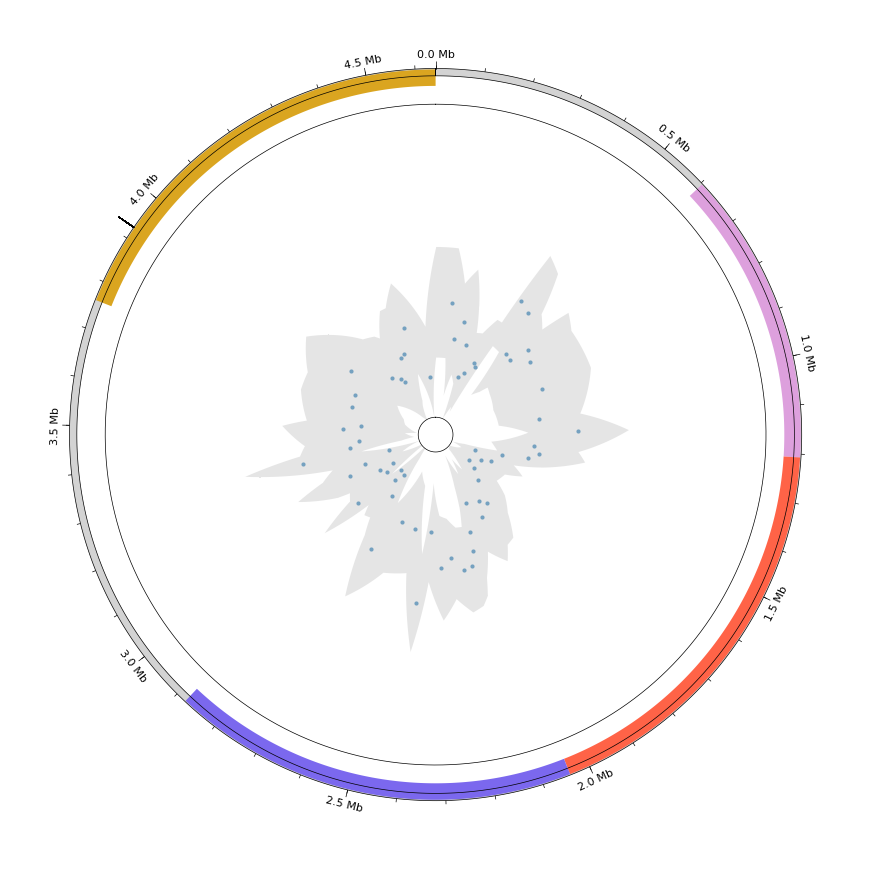

In [19]:
coordinates_file_oldPole = '240528_localization_data_radial_repInput_oldPole.csv'
coordinates_tbl_oldPole = pd.read_csv(coordinates_file_oldPole,sep = ',')

R_tbl_oldPole = pd.DataFrame()
R_std_tbl_oldPole = pd.DataFrame()
for g in genome_loci:
    R_tbl_oldPole[str(g)] = coordinates_tbl_oldPole[str(g)+'_muR']
    R_std_tbl_oldPole[str(g)] = coordinates_tbl_oldPole[str(g)+'_sigmaR']

R_tbl_oldPole.replace(0, np.nan, inplace=True)
R_std_tbl_oldPole.replace(0, np.nan, inplace=True)

N_MG1655 = 4641652

circos = Circos(sectors={gbk.name: gbk.range_size})
#circos.text("Escherichia coli\n(NC_000913)", size=12, r=20)
sector = circos.get_sector(gbk.name)

# Plot outer track with xticks
major_ticks_interval = 500000
minor_ticks_interval = 100000
outer_track = sector.add_track((98, 100))
outer_track.axis(fc="lightgrey")
outer_track.xticks_by_interval(
    major_ticks_interval, label_formatter=lambda v: f"{v/ 10 ** 6:.1f} Mb"
)
outer_track.xticks_by_interval(minor_ticks_interval, tick_length=1, show_label=False)

ori = gbk.extract_features("rep_origin")
outer_track.xticks(ori[0].location,tick_length=5)

MD_track = sector.add_track((95, 100), r_pad_ratio=0.1)
MD_track.genomic_features(gbk.extract_features("Ori_MD"), fc="goldenrod")
MD_track.genomic_features(gbk.extract_features("Right_MD", target_strand=1), fc="plum")
MD_track.genomic_features(gbk.extract_features("Terminus_MD", target_strand=1), fc="tomato")
MD_track.genomic_features(gbk.extract_features("Left_MD", target_strand=1), fc="mediumslateblue")

cellRadius = 0.47

R_track = sector.add_track((0, 95), r_pad_ratio=0.1)
x = genome_loci
y = R_tbl_oldPole.mean(axis=0).values
R_track.scatter(x,y,vmin=0, vmax=cellRadius)
R_track.line([0,N_MG1655],[0, 0],vmin=0, vmax=cellRadius, color='k')
R_track.line([0,N_MG1655],[cellRadius, cellRadius],vmin=0, vmax=cellRadius, color='k')

S_track = sector.add_track((0, 95), r_pad_ratio=0.1)
x = genome_loci
s = R_std_tbl_oldPole.mean(axis=0).values
x = np.append(0,np.append(x,N_MG1655))
y = R_tbl_oldPole.mean(axis=0).values
y = np.append(y[0],np.append(y,y[0]))
s = np.append(s[0],np.append(s,s[0]))
t1 = y+s
t2 = y-s
t1[t1>cellRadius] = cellRadius
t2[t2<0] = 0
S_track.fill_between(x,t1,t2,vmin=0, vmax=cellRadius, color=[0.8, 0.8, 0.8], alpha=0.5)


#print(R_tbl_oldPole)
fig = circos.plotfig()
fig.savefig('FigSx-RadialOldPole.png')
fig.savefig('FigSx-RadialOldPole.pdf')


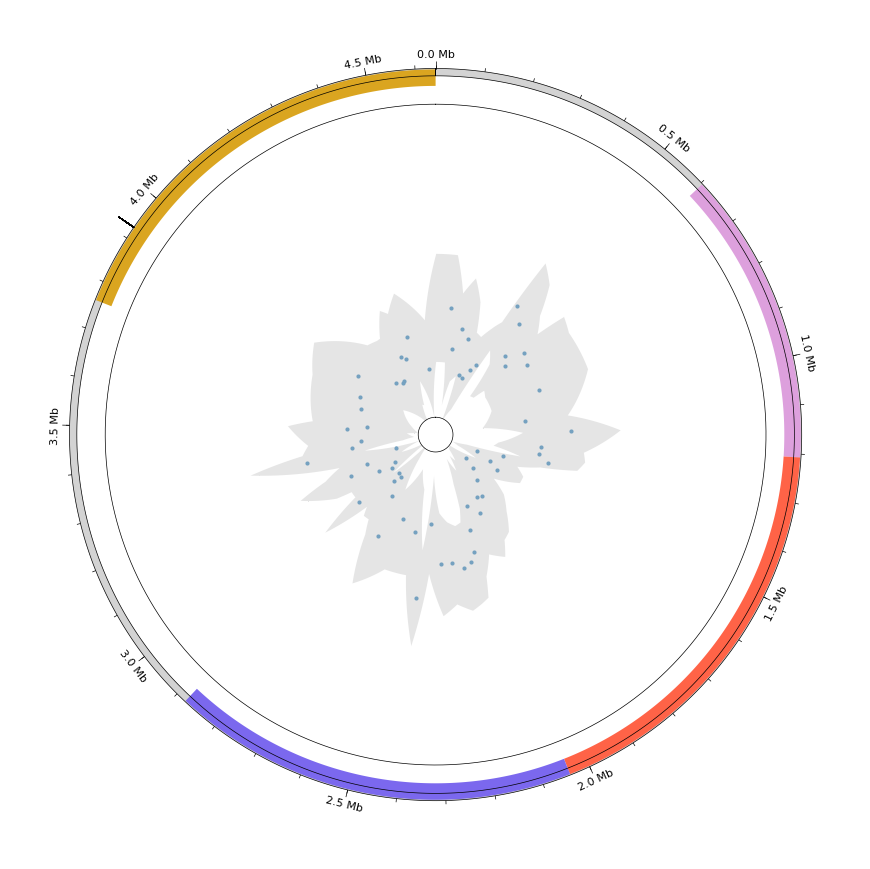

In [20]:
coordinates_file_newPole = '240528_localization_data_radial_repInput_newPole.csv'
coordinates_tbl_newPole = pd.read_csv(coordinates_file_newPole,sep = ',')

R_tbl_newPole = pd.DataFrame()
R_std_tbl_newPole = pd.DataFrame()
for g in genome_loci:
    R_tbl_newPole[str(g)] = coordinates_tbl_newPole[str(g)+'_muR']
    R_std_tbl_newPole[str(g)] = coordinates_tbl_newPole[str(g)+'_sigmaR']

R_tbl_newPole.replace(0, np.nan, inplace=True)
R_std_tbl_newPole.replace(0, np.nan, inplace=True)

N_MG1655 = 4641652

circos = Circos(sectors={gbk.name: gbk.range_size})
#circos.text("Escherichia coli\n(NC_000913)", size=12, r=20)
sector = circos.get_sector(gbk.name)

# Plot outer track with xticks
major_ticks_interval = 500000
minor_ticks_interval = 100000
outer_track = sector.add_track((98, 100))
outer_track.axis(fc="lightgrey")
outer_track.xticks_by_interval(
    major_ticks_interval, label_formatter=lambda v: f"{v/ 10 ** 6:.1f} Mb"
)
outer_track.xticks_by_interval(minor_ticks_interval, tick_length=1, show_label=False)

ori = gbk.extract_features("rep_origin")
outer_track.xticks(ori[0].location,tick_length=5)

MD_track = sector.add_track((95, 100), r_pad_ratio=0.1)
MD_track.genomic_features(gbk.extract_features("Ori_MD"), fc="goldenrod")
MD_track.genomic_features(gbk.extract_features("Right_MD", target_strand=1), fc="plum")
MD_track.genomic_features(gbk.extract_features("Terminus_MD", target_strand=1), fc="tomato")
MD_track.genomic_features(gbk.extract_features("Left_MD", target_strand=1), fc="mediumslateblue")

cellRadius = 0.47

R_track = sector.add_track((0, 95), r_pad_ratio=0.1)
x = genome_loci
y = R_tbl_newPole.mean(axis=0).values
R_track.scatter(x,y,vmin=0, vmax=cellRadius)
R_track.line([0,N_MG1655],[0, 0],vmin=0, vmax=cellRadius, color='k')
R_track.line([0,N_MG1655],[cellRadius, cellRadius],vmin=0, vmax=cellRadius, color='k')

S_track = sector.add_track((0, 95), r_pad_ratio=0.1)
x = genome_loci
s = R_std_tbl_newPole.mean(axis=0).values
x = np.append(0,np.append(x,N_MG1655))
y = R_tbl_newPole.mean(axis=0).values
y = np.append(y[0],np.append(y,y[0]))
s = np.append(s[0],np.append(s,s[0]))
t1 = y+s
t2 = y-s
t1[t1>cellRadius] = cellRadius
t2[t2<0] = 0
S_track.fill_between(x,t1,t2,vmin=0, vmax=cellRadius, color=[0.8, 0.8, 0.8], alpha=0.5)


#print(R_tbl_newPole)
fig = circos.plotfig()
fig.savefig('FigSx-RadialNewPole.png')
fig.savefig('FigSx-RadialNewPole.pdf')


C:\Users\dvisi988\Anaconda3\lib\site-packages\pycirclize\circos.py:1120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize, dpi=dpi, tight_layout=True)


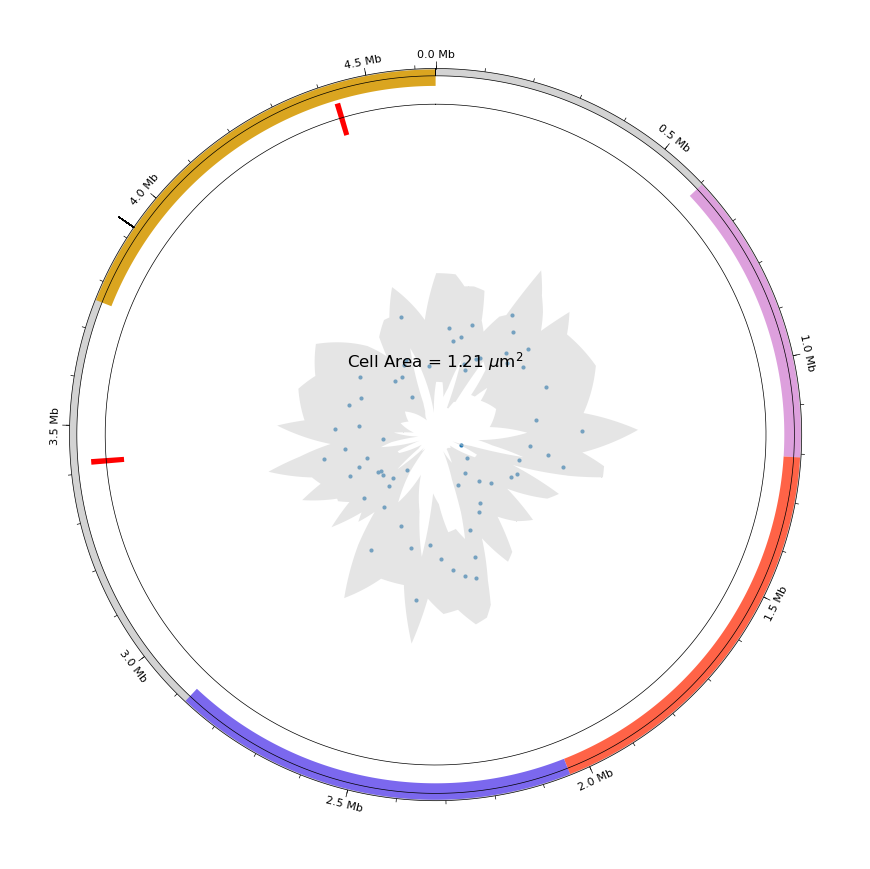

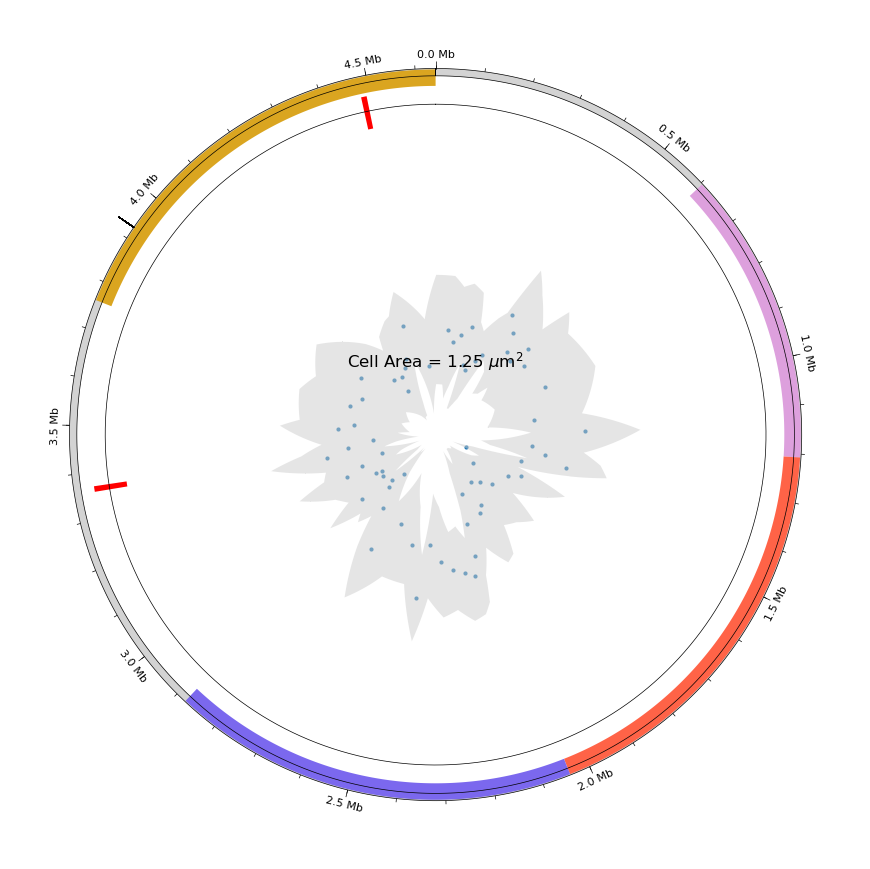

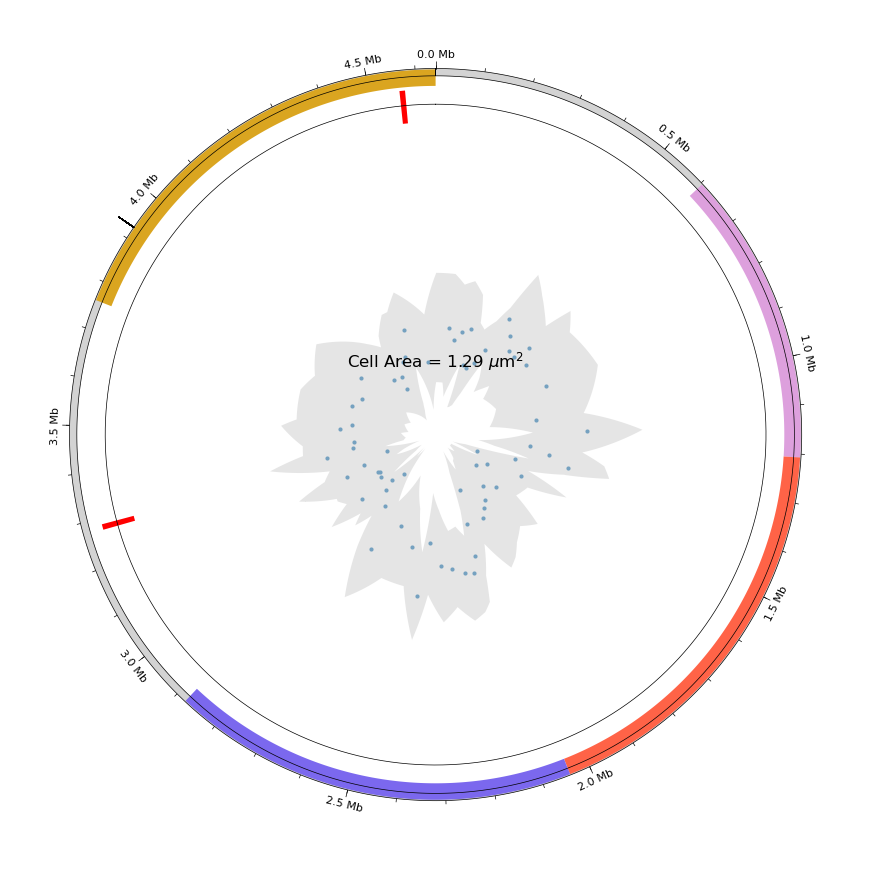

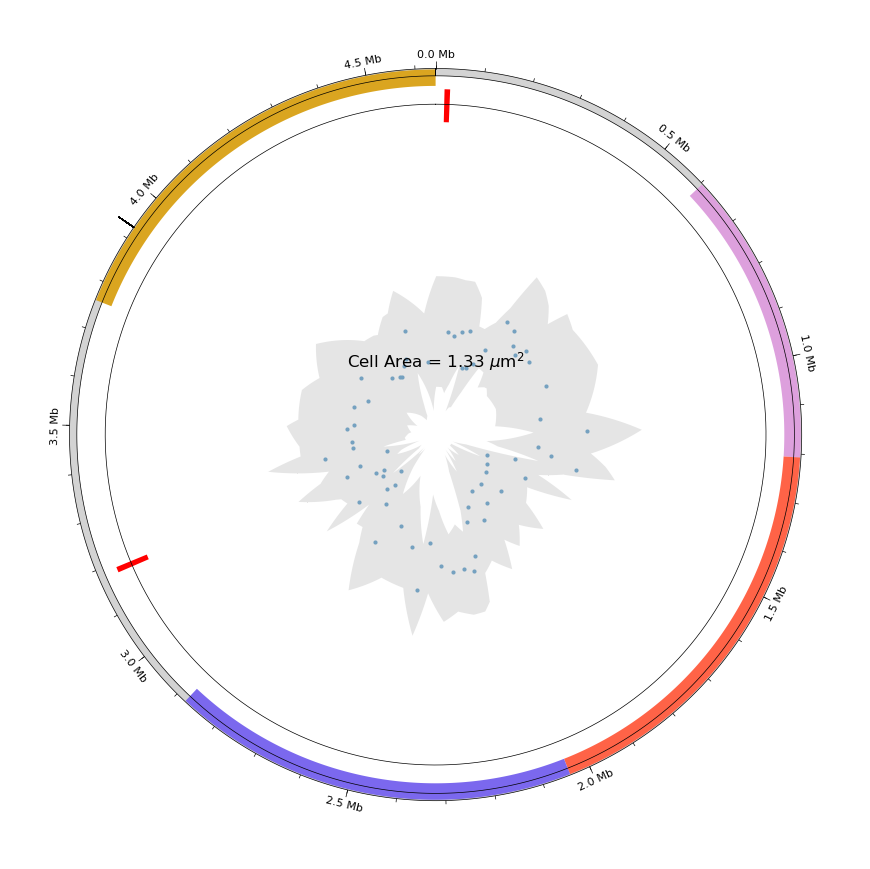

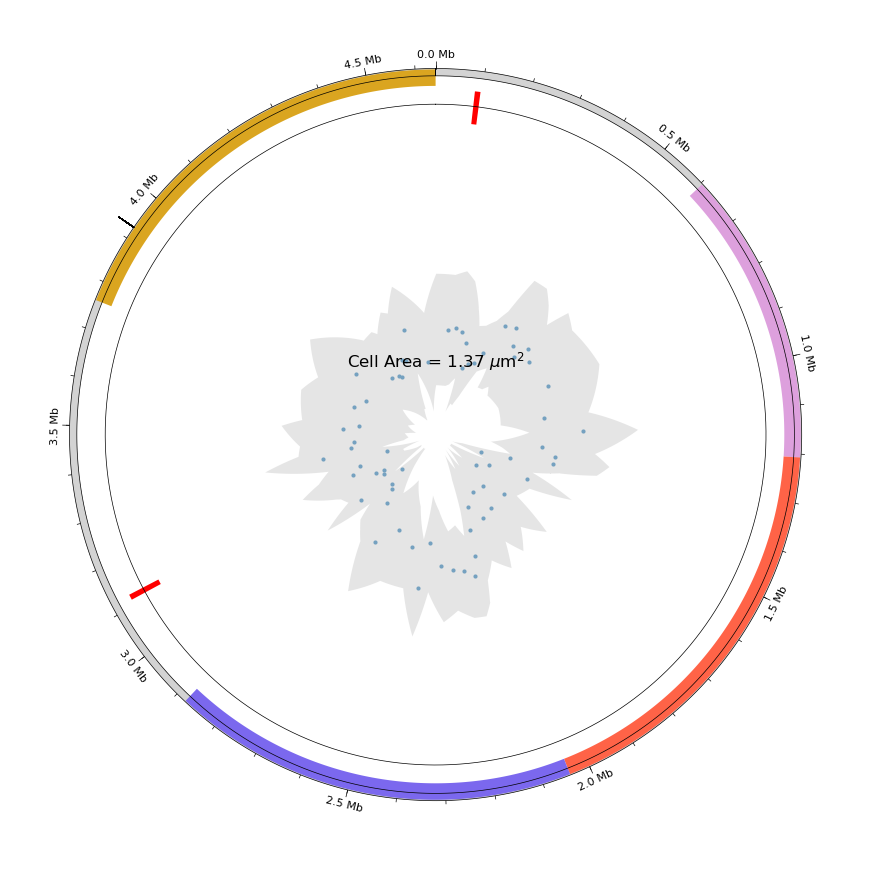

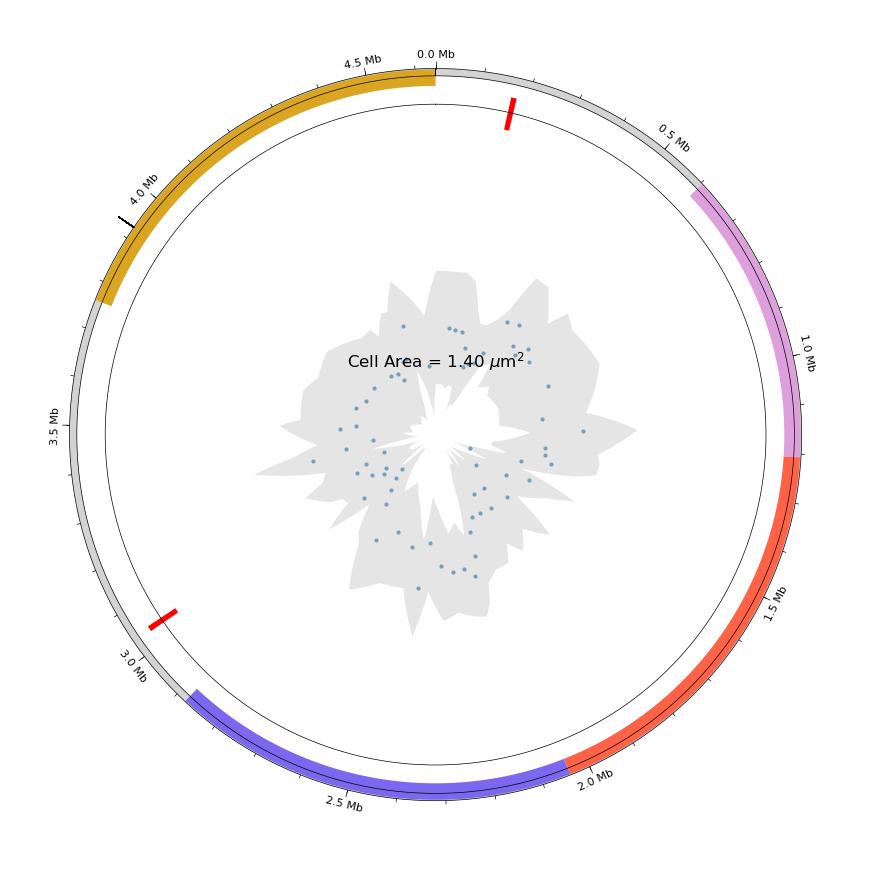

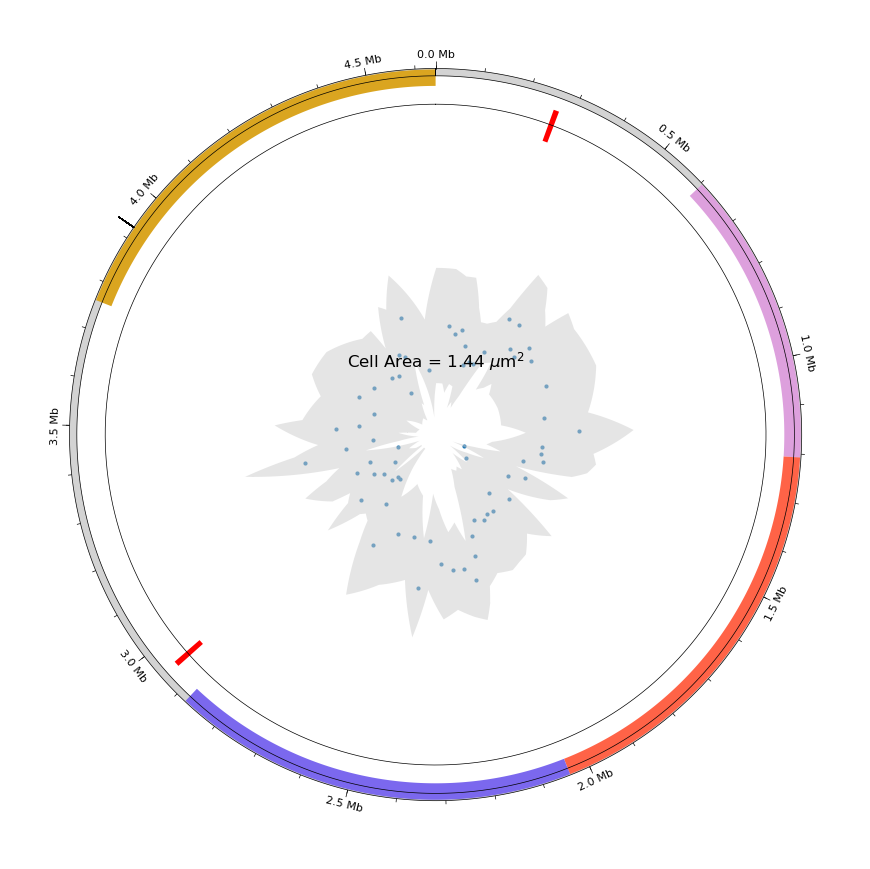

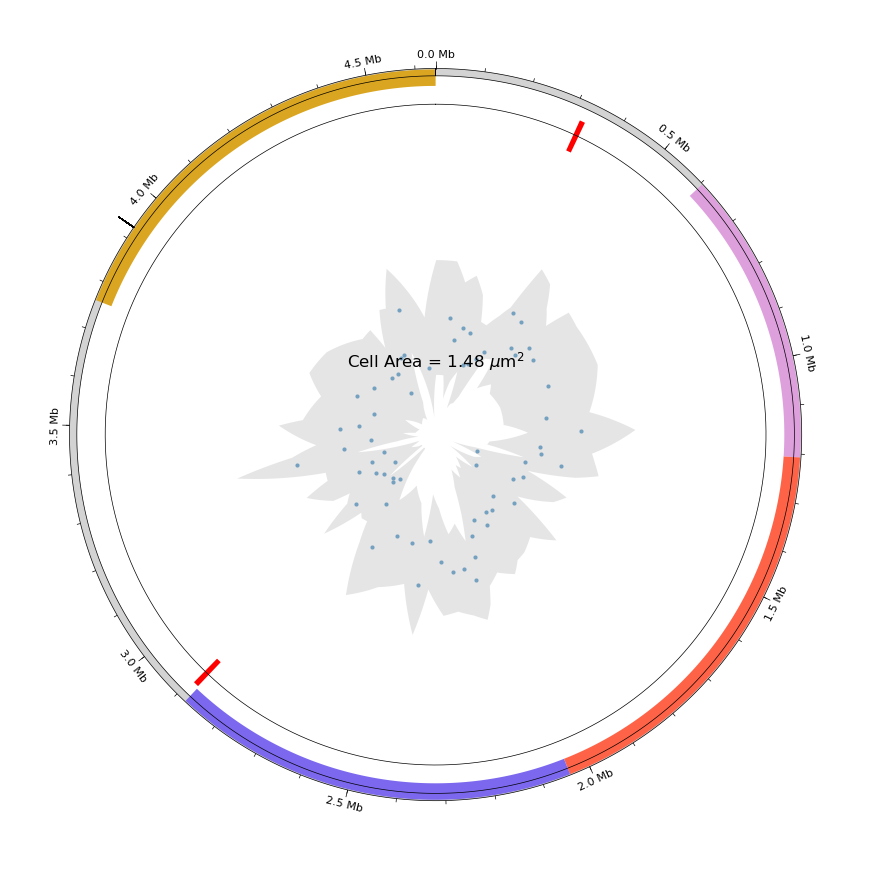

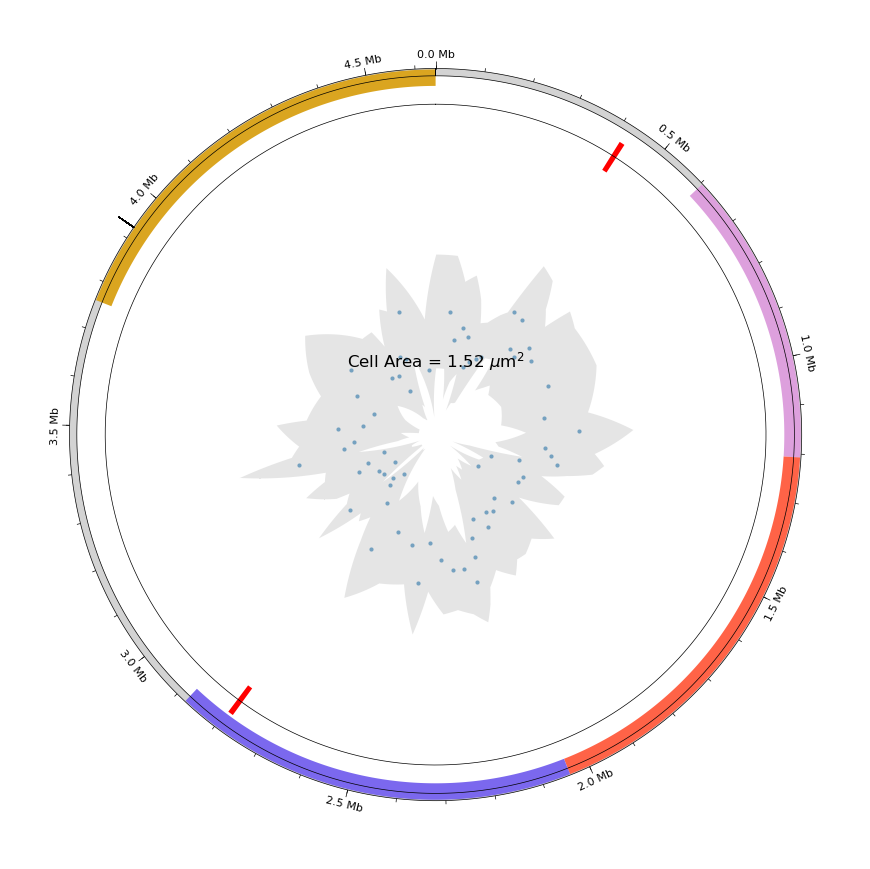

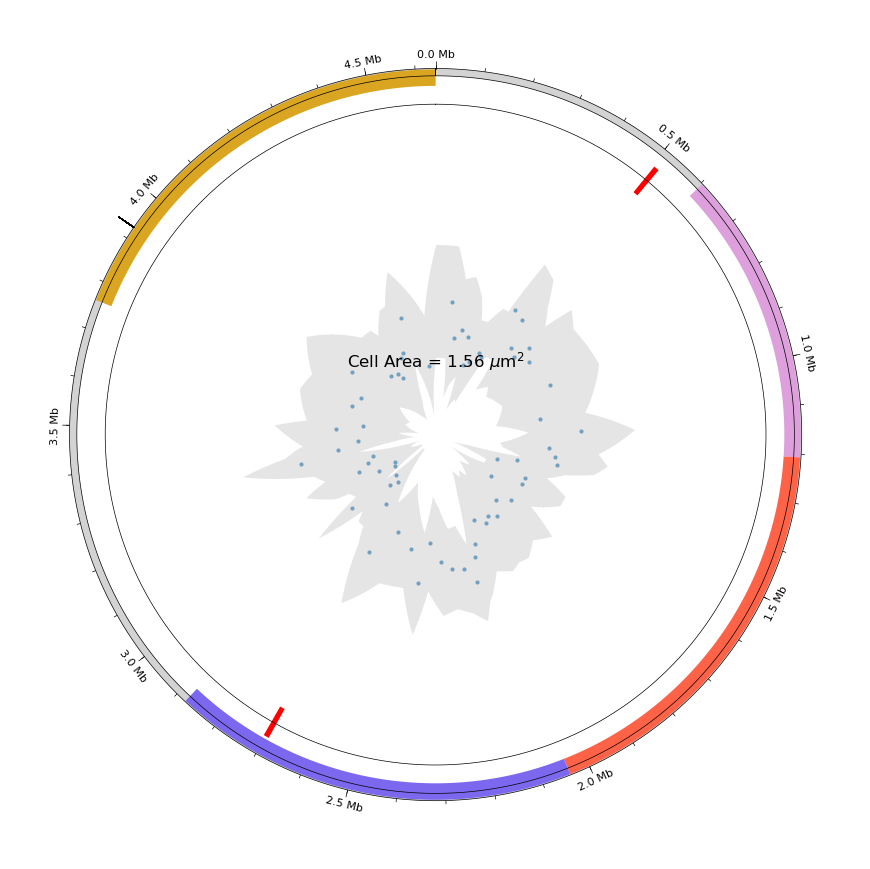

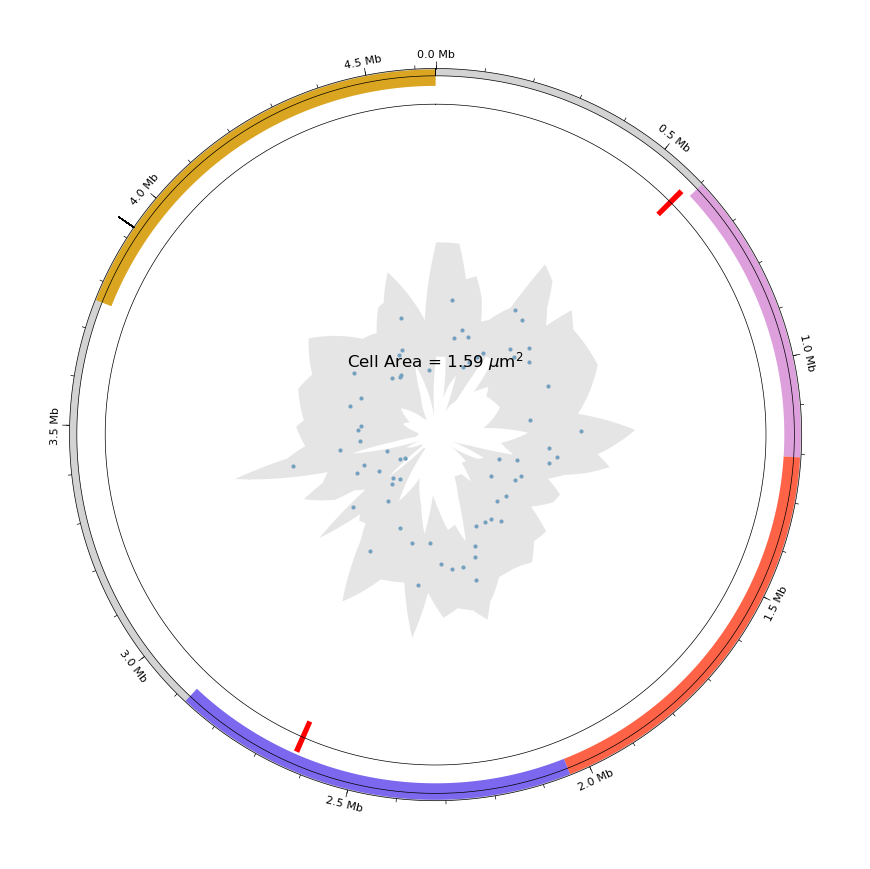

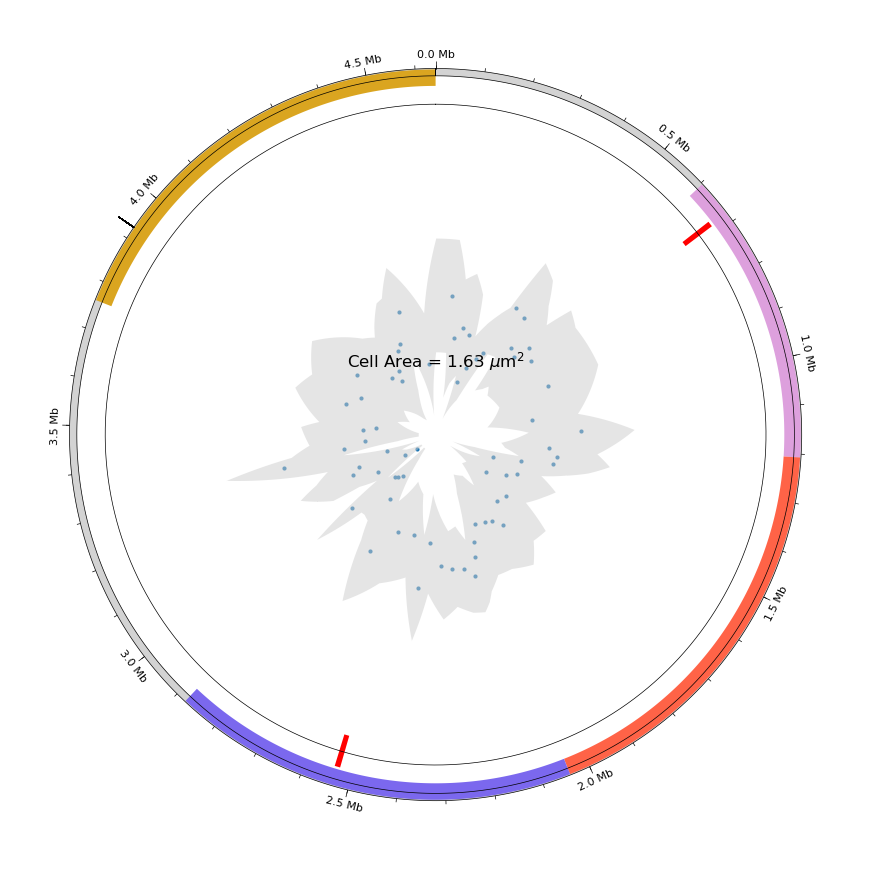

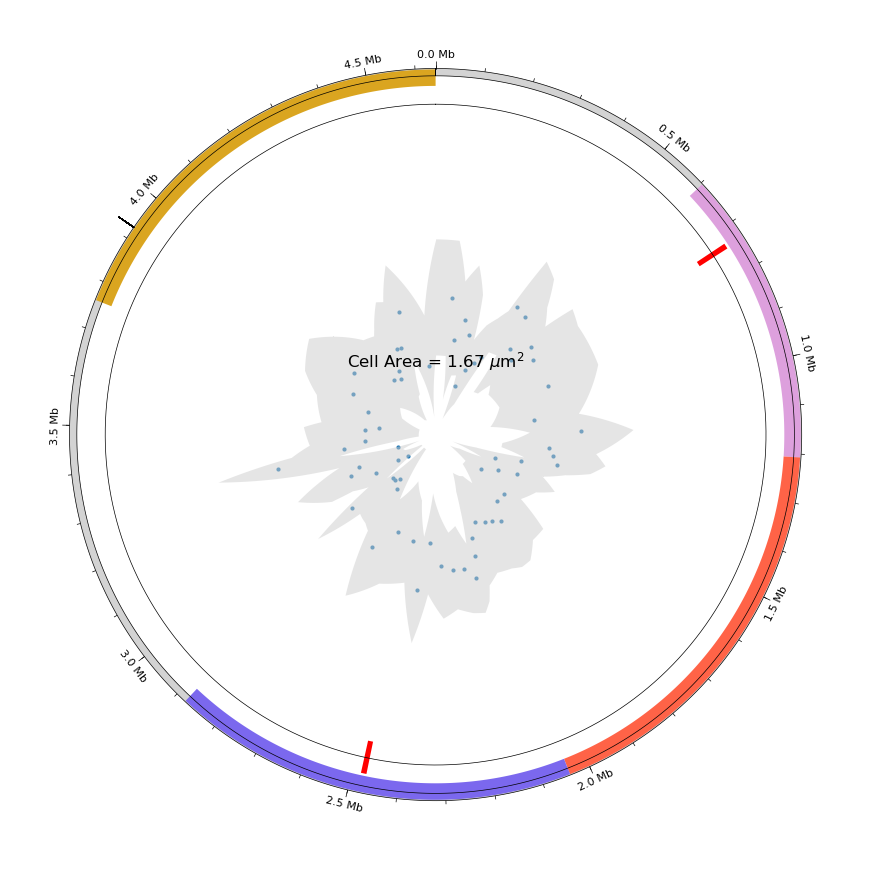

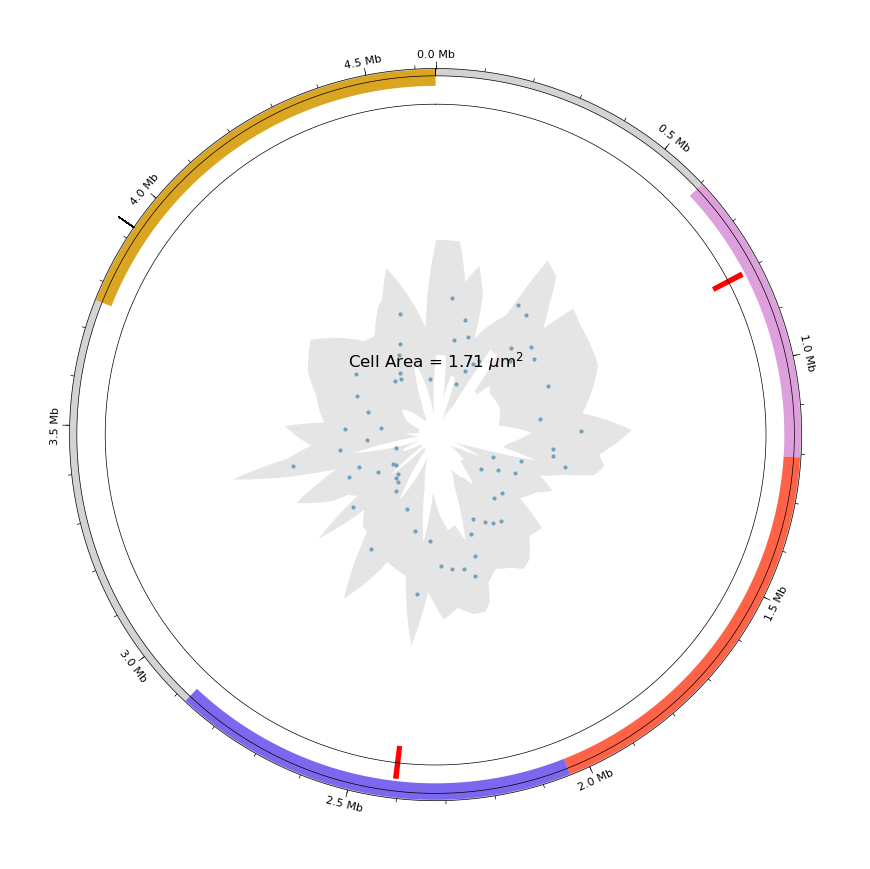

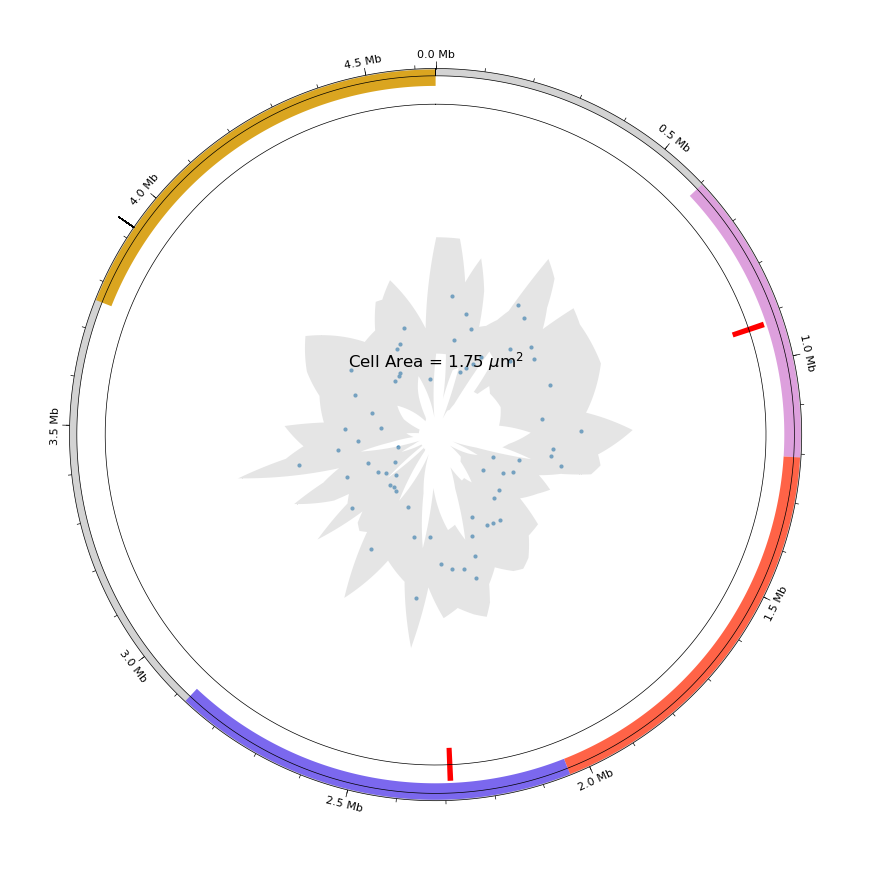

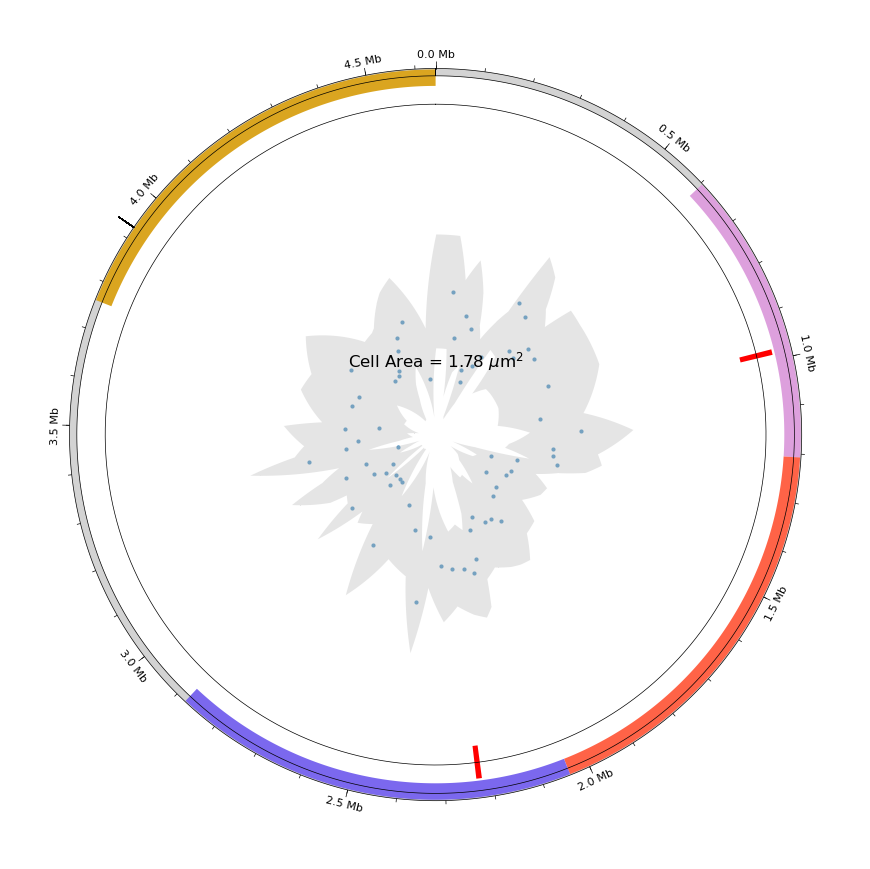

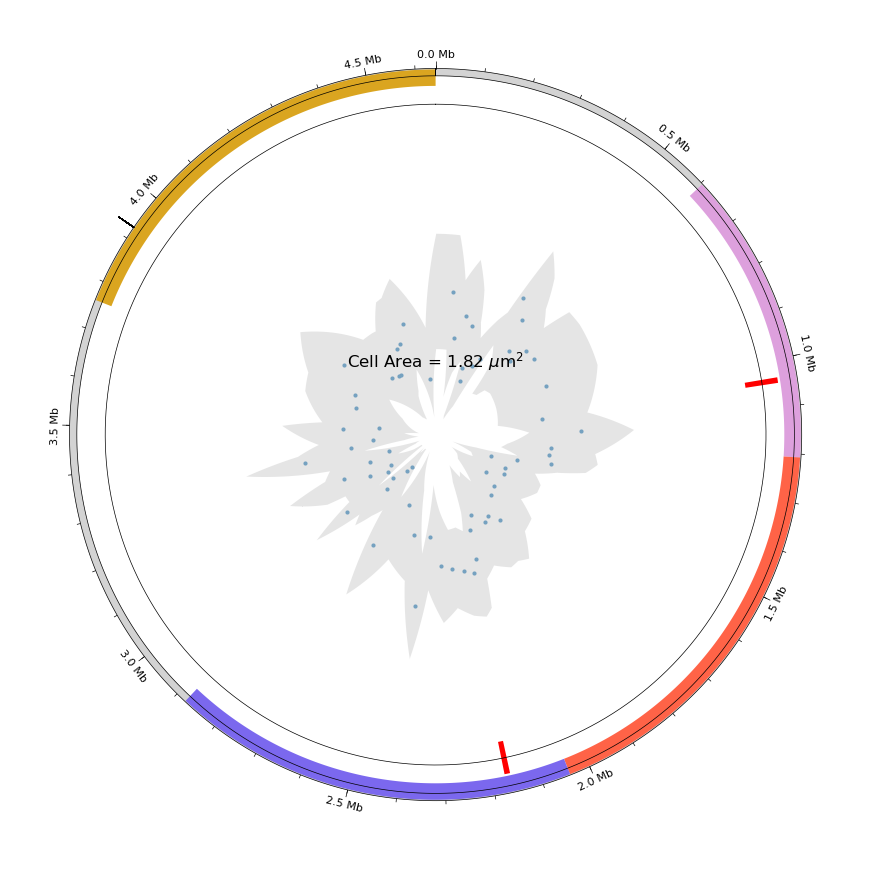

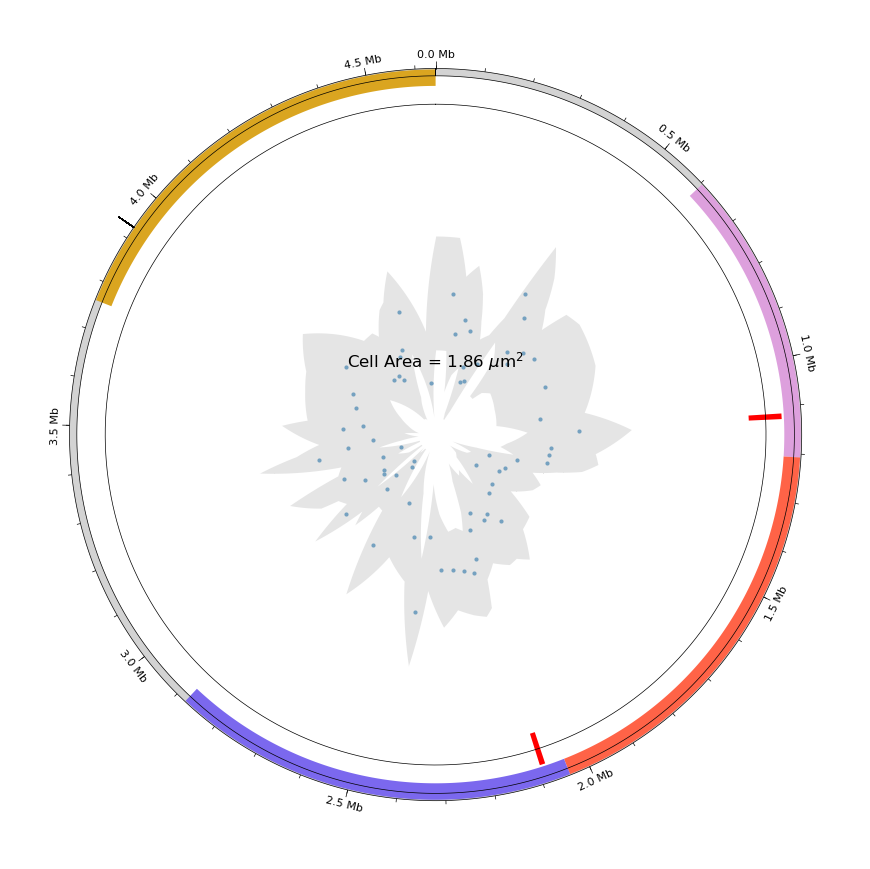

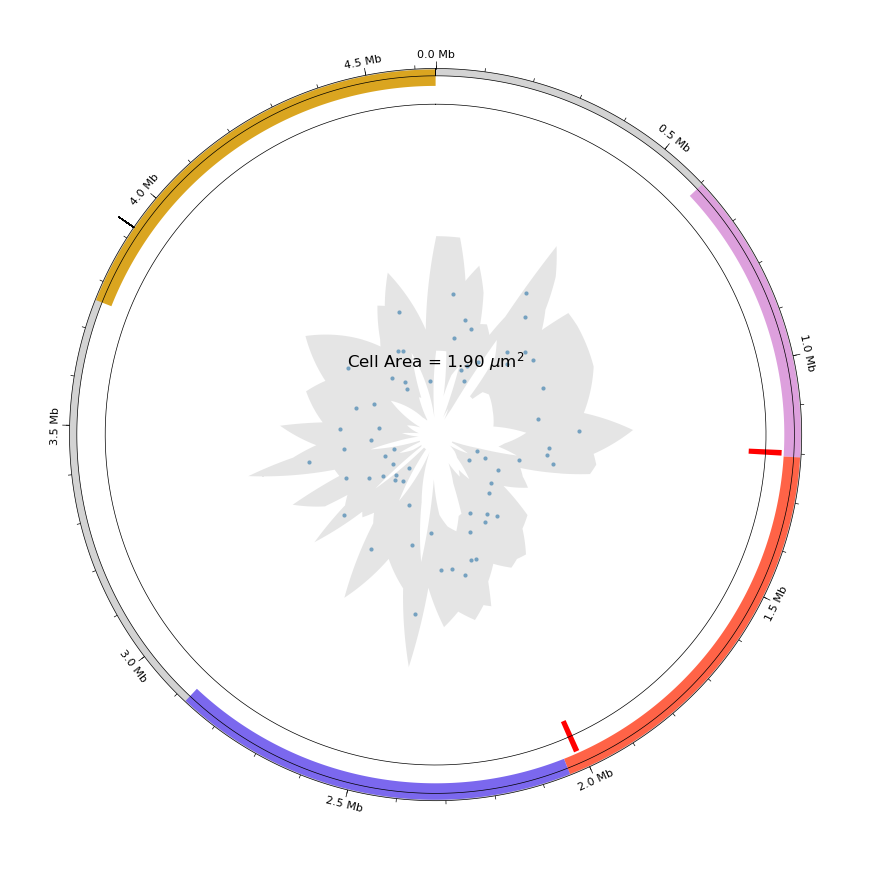

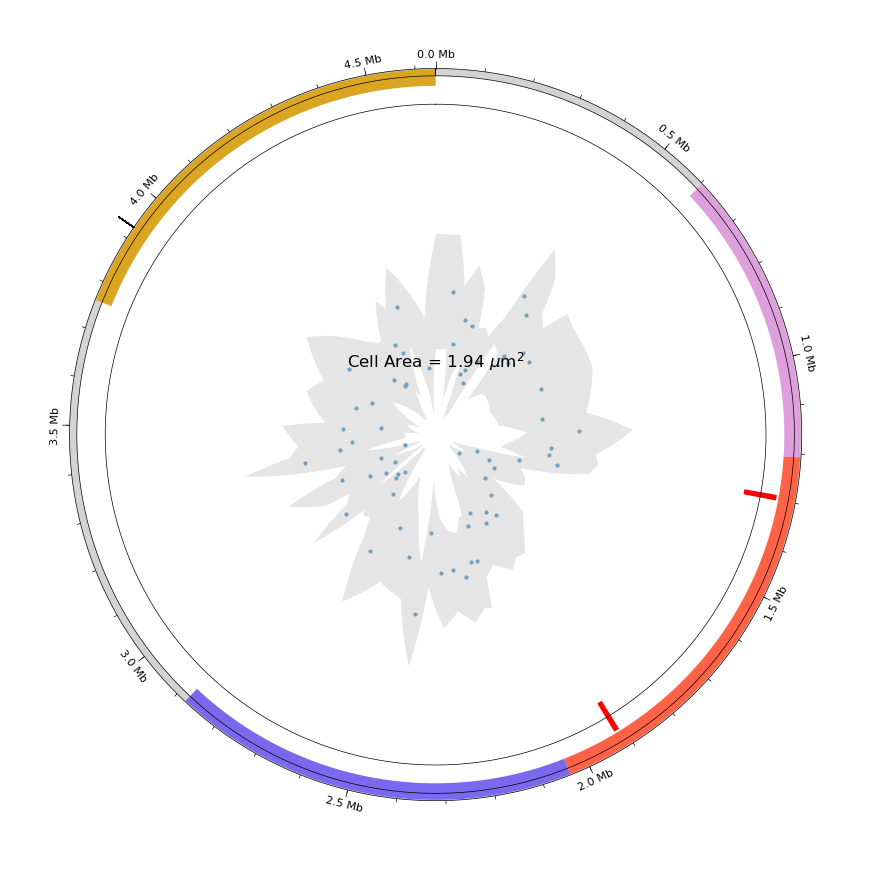

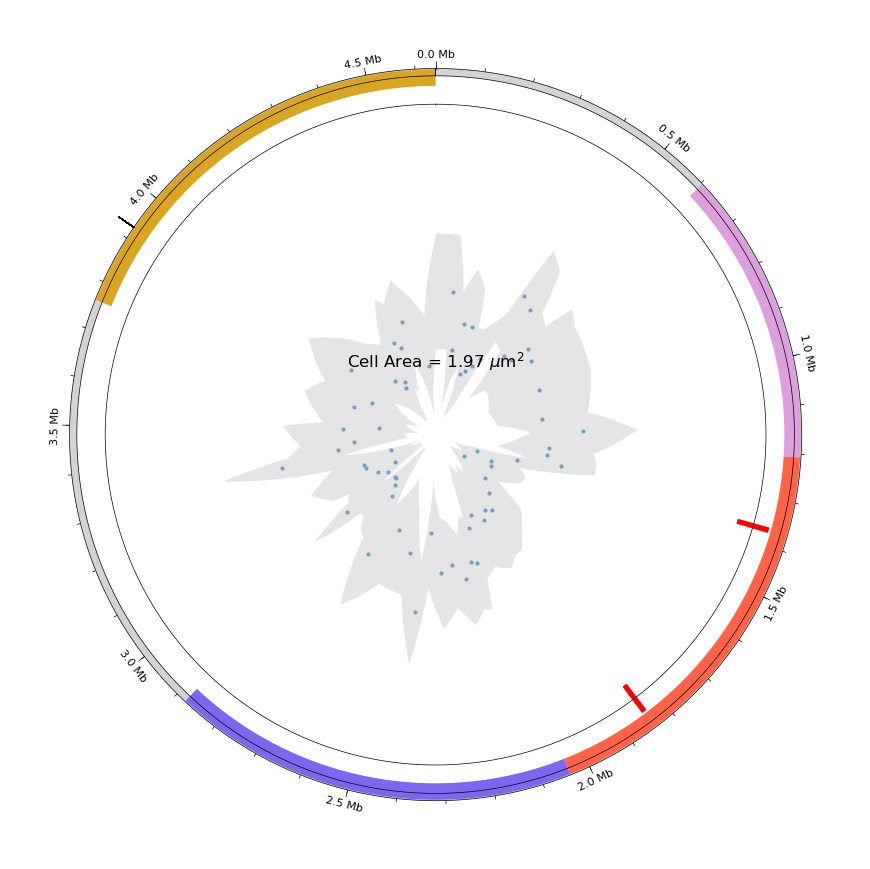

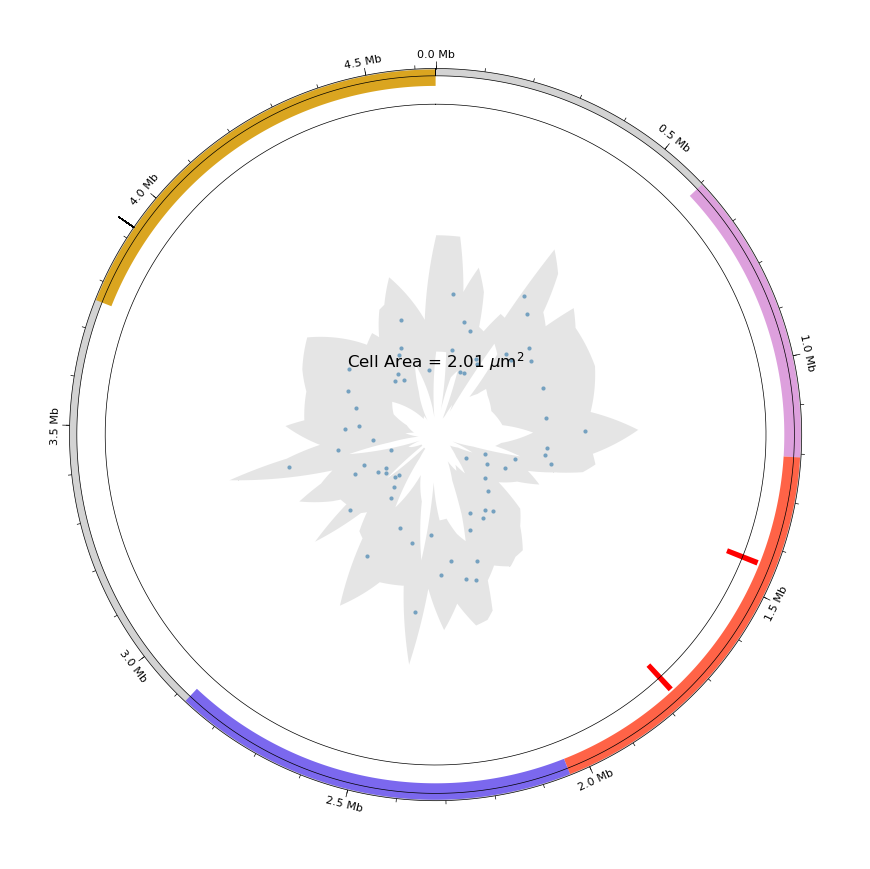

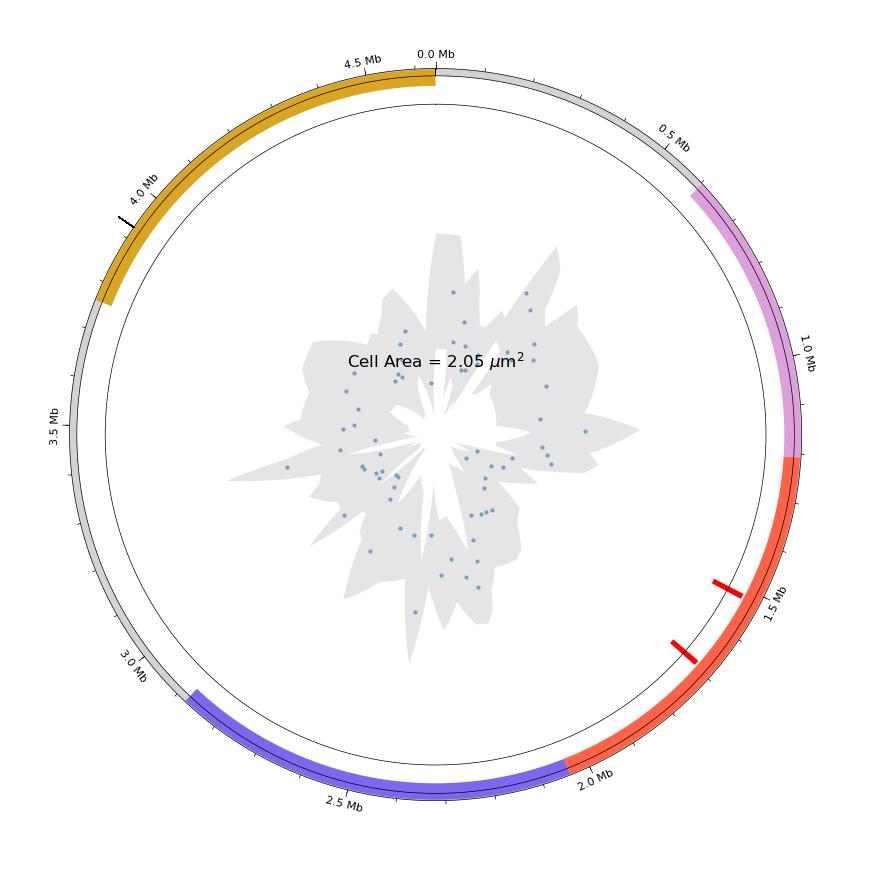

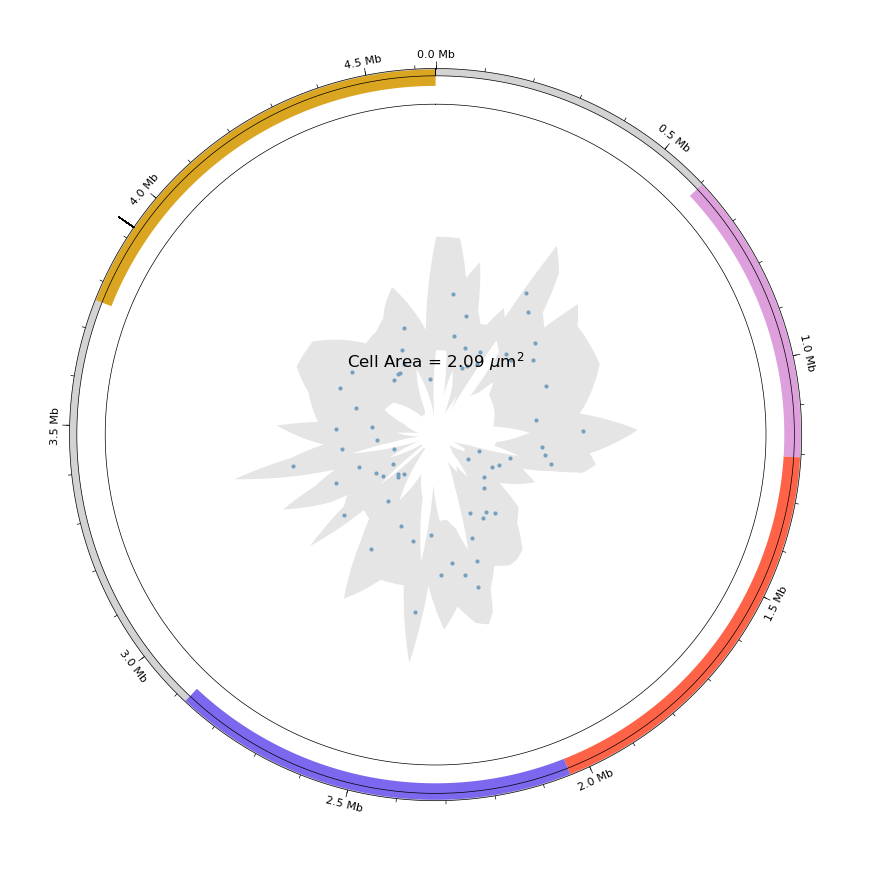

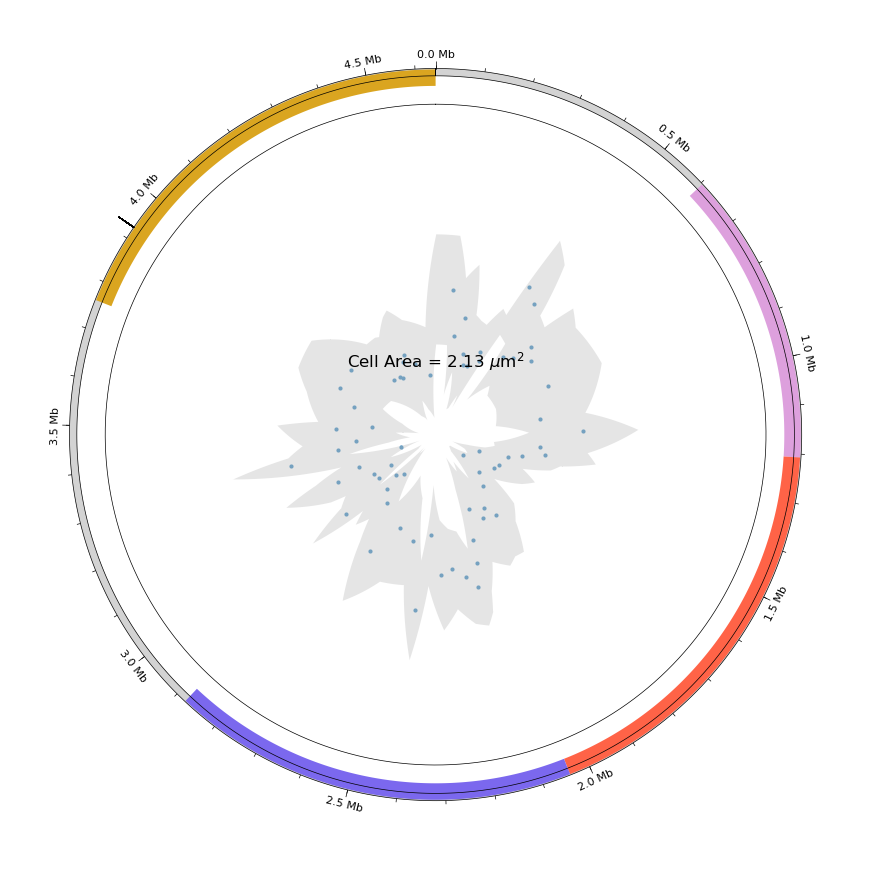

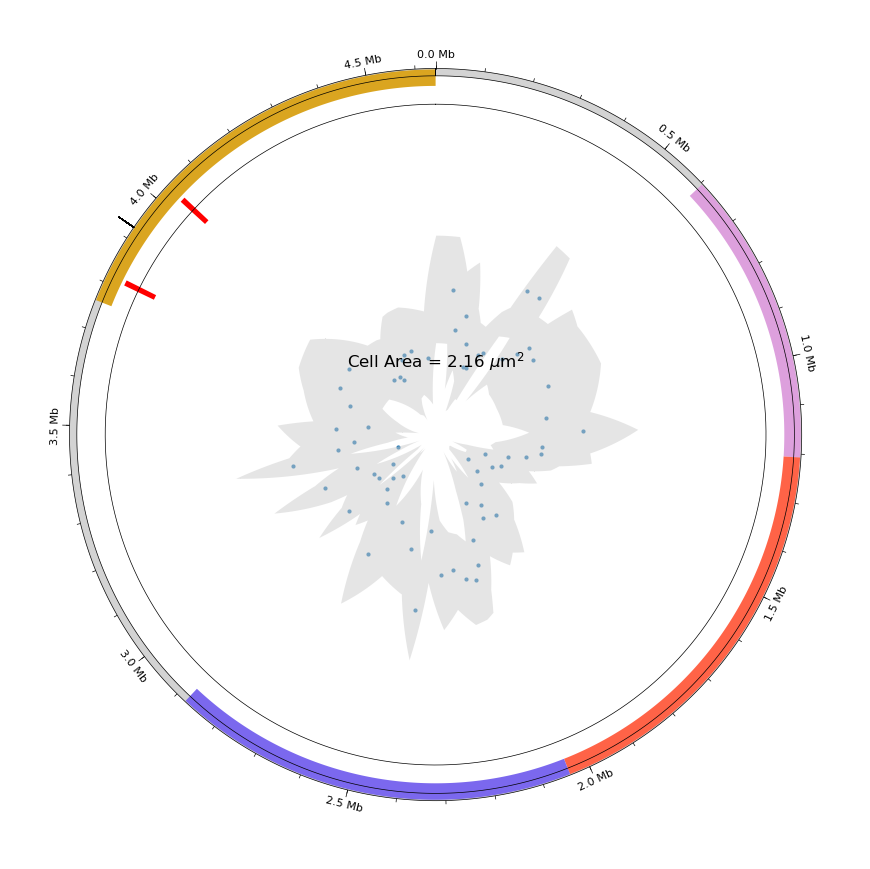

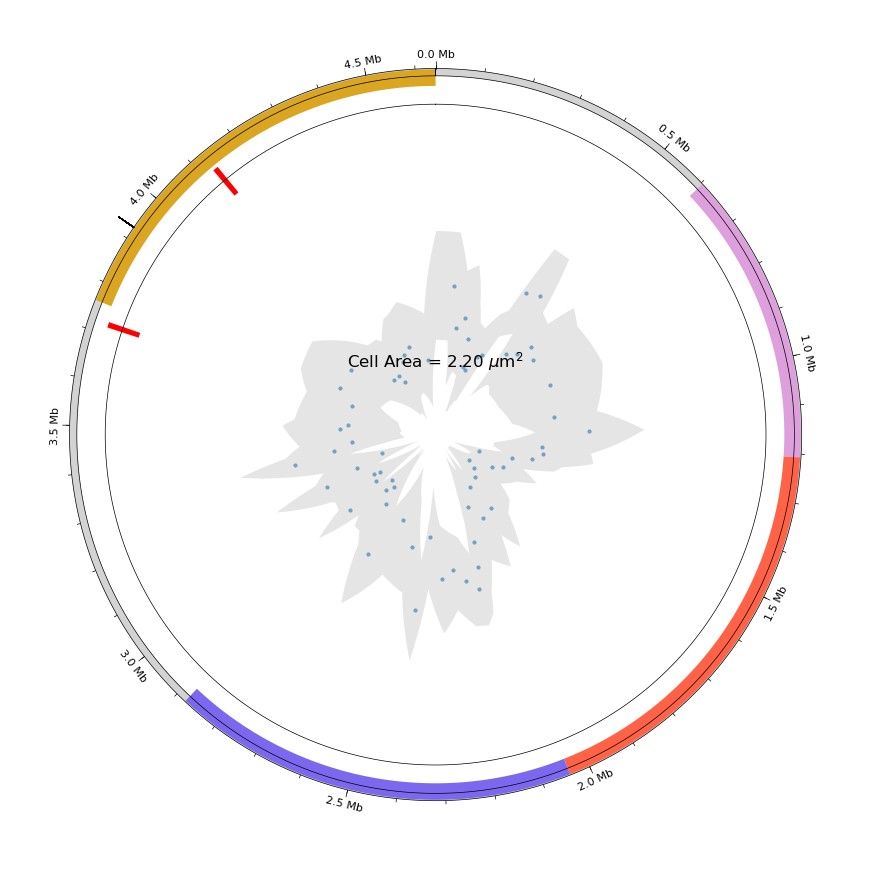

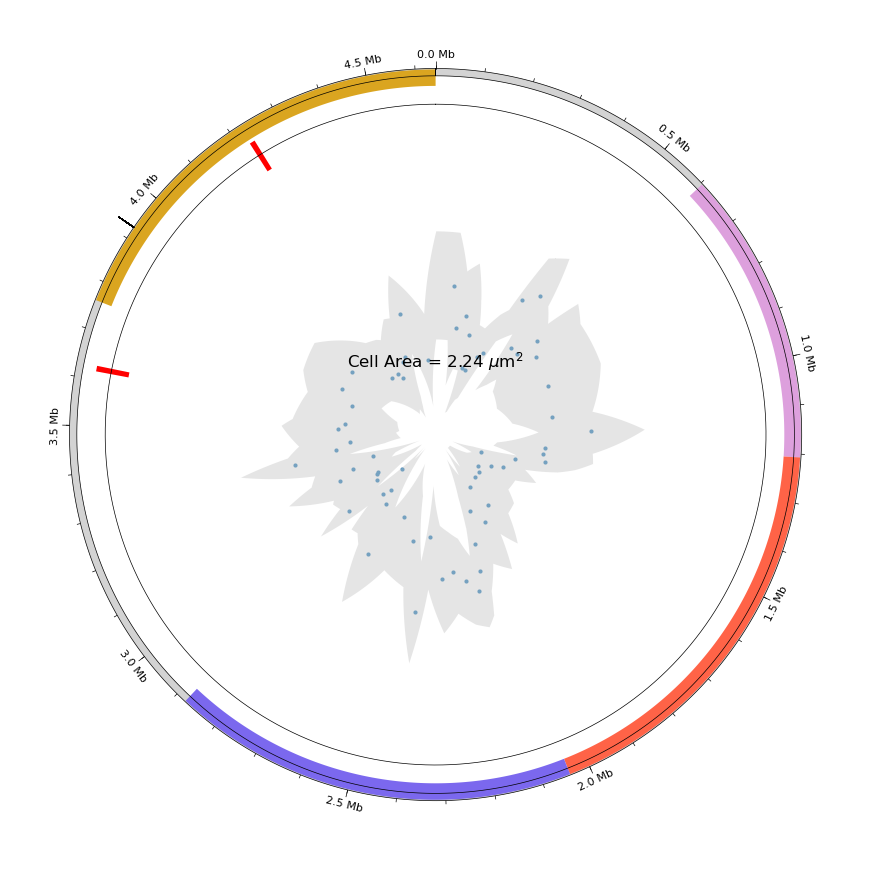

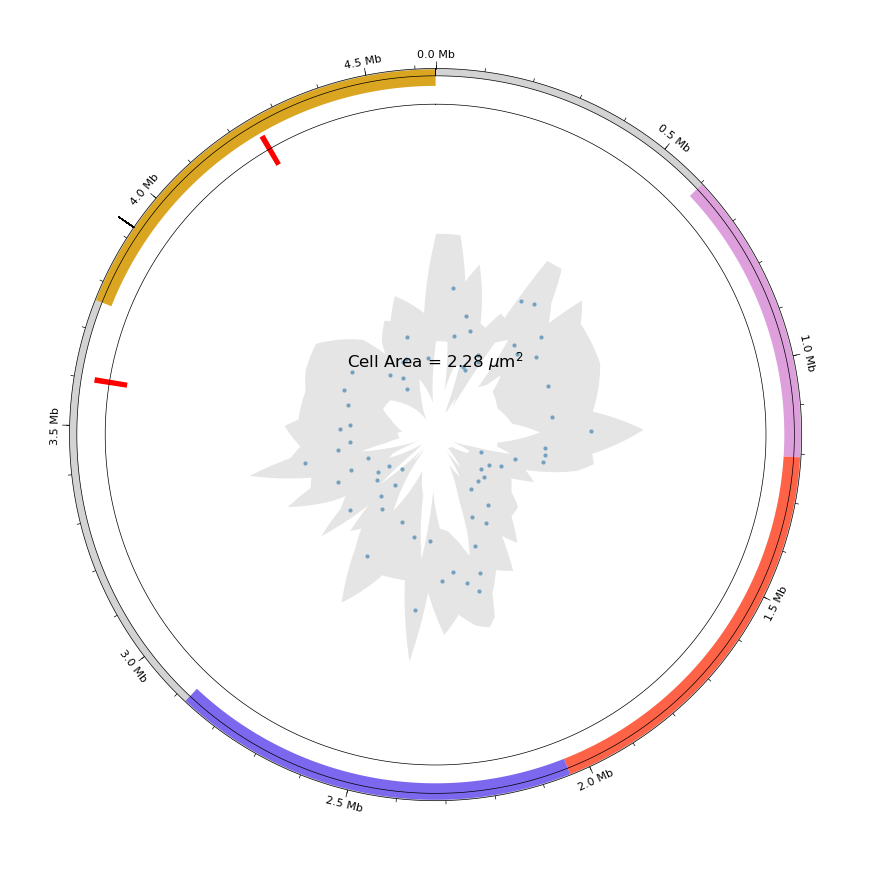

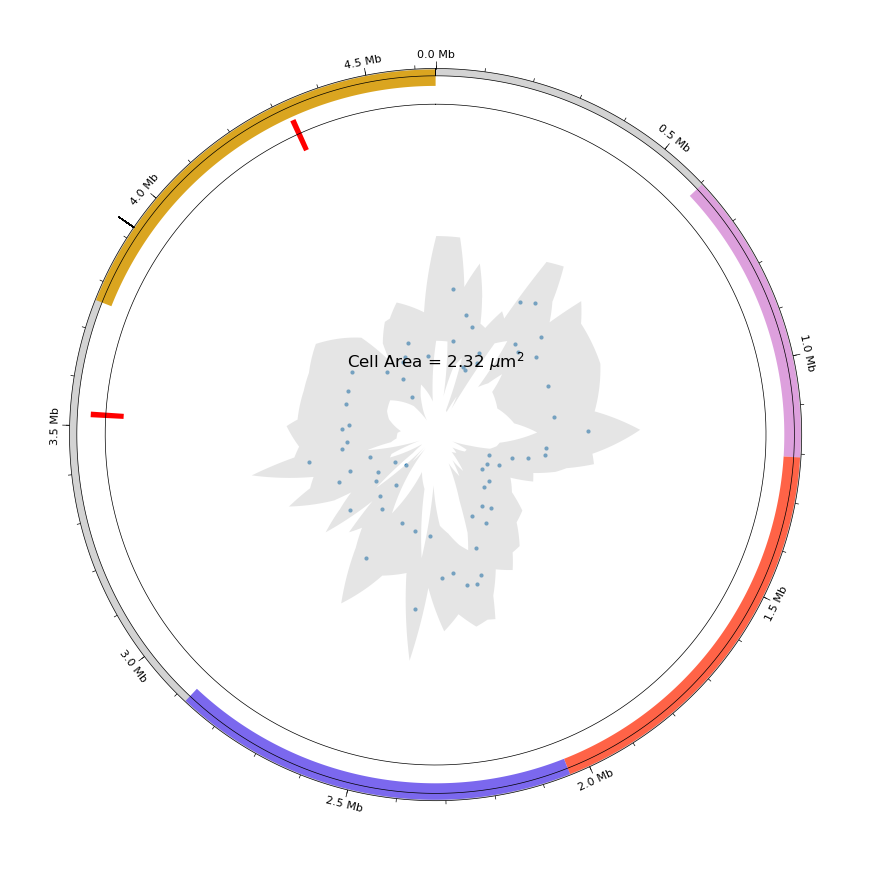

In [21]:
import os

out_folder = 'meanR_std_sizeBinned/'
if not os.path.isdir(out_folder):
    os.mkdir(out_folder)

    
N_MG1655 = 4641652
oriC_site = 3925860
ter_site = oriC_site-N_MG1655/2
    
mu2df = coordinates_tbl.filter(regex='mu2')
mu3df = coordinates_tbl.filter(regex='mu3')

repForkPos = [[],[]]
Linds = np.where(np.logical_and(genome_loci<oriC_site,genome_loci>ter_site))
Linds = Linds[0]
Rinds = np.setdiff1d(range(len(genome_loci)),Linds)
#print(Linds)
for row2, row3 in zip(mu2df.iterrows(), mu3df.iterrows()):
    inds2 = np.where(np.isnan(row2[1].values))[0]
    inds3 = np.where(np.isnan(row3[1].values))[0]
    if inds2.any():
        #print(inds2)
        repForkDist = np.min(distance_to_ori[inds2]) 
    elif inds3.any():  
        if len(inds3)==len(genome_loci):
            repForkPos[0].append(np.nan)
            repForkPos[1].append(np.nan)
            continue
        #print(inds3)
        repForkDist = np.min(distance_to_ori[inds3])
    repForkPos[0].append(np.mod(oriC_site + repForkDist,N_MG1655))
    repForkPos[1].append(np.mod(oriC_site - repForkDist,N_MG1655))
    

repForkPos = np.array(repForkPos) 
repForkPos = repForkPos.transpose()
#print(repForkPos)
    
cellRadius = 0.47
M0 = pd.read_excel('M00.xlsx')
#R_tbl = R_tbl.rolling(5, min_periods=1).mean()
#R_std_tbl = R_std_tbl.rolling(5, min_periods=1).mean()
for g, cellArea, row, Srow in zip(repForkPos, M0['cellArea'], R_tbl.iterrows(), R_std_tbl.iterrows()):
    del circos
    
    circos = Circos(sectors={gbk.name: gbk.range_size})
   
    sector = circos.get_sector(gbk.name)

    # Plot outer track with xticks
    major_ticks_interval = 500000
    minor_ticks_interval = 100000
    outer_track = sector.add_track((98, 100))
    outer_track.axis(fc="lightgrey")
    outer_track.xticks_by_interval(
        major_ticks_interval, label_formatter=lambda v: f"{v/ 10 ** 6:.1f} Mb"
    )
    outer_track.xticks_by_interval(minor_ticks_interval, tick_length=1, show_label=False)

    ori = gbk.extract_features("rep_origin")
    outer_track.xticks(ori[0].location,tick_length=5)

    MD_track = sector.add_track((95, 100), r_pad_ratio=0.1)
    MD_track.genomic_features(gbk.extract_features("Ori_MD"), fc="goldenrod")
    MD_track.genomic_features(gbk.extract_features("Right_MD", target_strand=1), fc="plum")
    MD_track.genomic_features(gbk.extract_features("Terminus_MD", target_strand=1), fc="tomato")
    MD_track.genomic_features(gbk.extract_features("Left_MD", target_strand=1), fc="mediumslateblue")
    
    y = row[1].values
    x = genome_loci
    R_track = sector.add_track((0, 95), r_pad_ratio=0.1)
    #R_track.line([0,N_MG1655],[0, 0],vmin=0, vmax=0.4, color='k')
    R_track.line([0,N_MG1655],[cellRadius, cellRadius],vmin=0, vmax=cellRadius, color='k')
    R_track.scatter(x,y,vmin=0, vmax=cellRadius)
    
    rep_track = sector.add_track((85, 95), r_pad_ratio=0.1)
    if not np.isnan(g[0]):
        rep_track.fill_between([g[0]-6e3, g[0]+6e3], [0, 0], [1, 1], vmin=0, vmax=1, color='r')
        rep_track.fill_between([g[1]-6e3, g[1]+6e3], [0, 0], [1, 1], vmin=0, vmax=1, color='r')
    
    S_track = sector.add_track((0, 95), r_pad_ratio=0.1)
    x = genome_loci
    s = Srow[1].values
    x = np.append(0,np.append(x,N_MG1655))
    y = row[1].values
    y = np.append(y[0],np.append(y,y[0]))
    s = np.append(s[0],np.append(s,s[0]))
    t1 = y+s
    t2 = y-s
    t1[t1>cellRadius] = cellRadius
    t2[t2<0] = 0
    S_track.fill_between(x,t1,t2,vmin=0, vmax=cellRadius, color=[0.8, 0.8, 0.8], alpha=0.5)
    
    
    circos.text(r'Cell Area = %1.2f $\mu$m$^2$' % cellArea, size=12, r=20)
    fig = circos.plotfig()
    fig.savefig('%smeanR_%1.2f.png' % (out_folder, cellArea) )
    fig.savefig('%smeanR_%1.2f.pdf' % (out_folder, cellArea) )
    fig.clear
    #fig.close()
    

(68, 1)
[0.20356178 0.208485   0.19896456 0.18382534 0.18223352 0.17910129
 0.17601906 0.17614208 0.17712821 0.17598741 0.16413378 0.15476256
 0.15157077 0.14420992 0.11644694 0.0981993  0.05856369 0.02895686
 0.03078519 0.0349853  0.03899682 0.03102658 0.03560015 0.04382959
 0.04303952 0.0402101  0.03964504 0.02530642 0.04001535 0.05958469
 0.06179142 0.0702205  0.06559716 0.0770004  0.08250257 0.0904784
 0.10476519 0.10912853 0.1181867  0.12737671 0.1445145  0.1623727
 0.16740187 0.17123279 0.1720848  0.17397504 0.18467727 0.18740584
 0.19632654 0.19401584 0.20287436 0.20176236 0.20667065 0.21663402
 0.21894404 0.22346327 0.24598341 0.24412567 0.24065566 0.24157761
 0.25251239 0.25603756 0.23769244 0.2251539  0.22271244 0.22521681
 0.2223732  0.21883237]


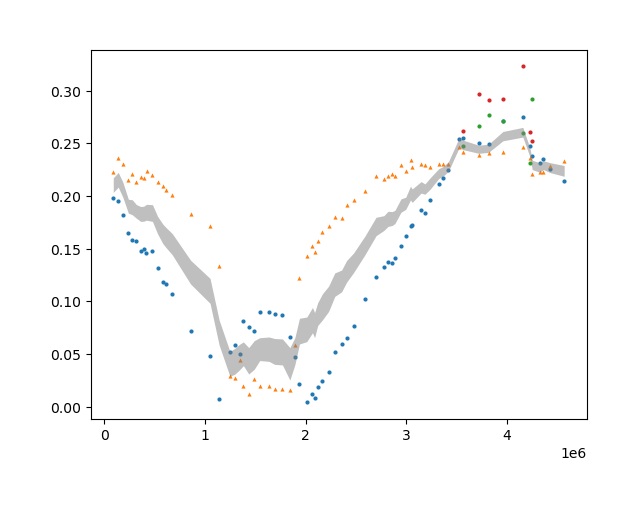

In [3]:
from copy import deepcopy
import matplotlib.pyplot as plt

x_tbl = deepcopy(coordinates_tbl)
x_std_tbl = deepcopy(coordinates_tbl)
#print(x_tbl)
for g in genome_loci:
    x_tbl.drop(str(g)+'_muR',axis=1,inplace=True)
    x_tbl.drop(str(g)+'_sigmaR',axis=1,inplace=True)
    x_tbl.drop(str(g)+'_sigma1',axis=1,inplace=True)
    x_tbl.drop(str(g)+'_sigma2',axis=1,inplace=True)
    x_tbl.drop(str(g)+'_sigma3',axis=1,inplace=True)
    x_tbl.drop(str(g)+'_sigma4',axis=1,inplace=True)
    x_std_tbl.drop(str(g)+'_sigmaR',axis=1,inplace=True)
    x_std_tbl.drop(str(g)+'_muR',axis=1,inplace=True)
    x_std_tbl.drop(str(g)+'_mu1',axis=1,inplace=True)
    x_std_tbl.drop(str(g)+'_mu2',axis=1,inplace=True)
    x_std_tbl.drop(str(g)+'_mu3',axis=1,inplace=True)
    x_std_tbl.drop(str(g)+'_mu4',axis=1,inplace=True)
    
#print(x_tbl)
df = x_tbl.filter(regex='mu1')
plt.scatter(genome_loci,np.abs(df.mean(axis=0)).values)
y = np.abs(df.mean(axis=0)).values
df = x_tbl.filter(regex='mu2')
plt.scatter(genome_loci+1e2,np.abs(df.mean(axis=0)).values,marker='^')
y += np.abs(df.mean(axis=0)).values
y = y/2
y = y.reshape((len(genome_loci),1))
df = x_tbl.filter(regex='mu3')
plt.scatter(genome_loci-1e2,np.abs(df.mean(axis=0)).values)
df = x_tbl.filter(regex='mu4')
plt.scatter(genome_loci+2e2,np.abs(df.mean(axis=0)).values)

s_vec = np.zeros((len(genome_loci),1))
for i,g in enumerate(genome_loci):
    s_tbl = x_std_tbl.filter(regex=str(g))
    tmp = s_tbl.mean(axis=1).values
    s_vec[i] = np.mean(tmp, axis=0)

print(np.shape(y-s_vec/2))
t1 = y-s_vec/2
t2 = y+s_vec/2
print(t1[:,0])
plt.fill_between(genome_loci, t1[:,0] , t2[:,0],color='grey',alpha=0.5 )
plt.show()
#print(df)


In [56]:
import os
from palettable.tableau import Tableau_10 as Color_set
from copy import deepcopy
import matplotlib.pyplot as plt

out_folder = 'longAxis_std_sizeBinned/'
if not os.path.isdir(out_folder):
    os.mkdir(out_folder)

x_tbl = deepcopy(coordinates_tbl)
x_std_tbl = deepcopy(coordinates_tbl)
#print(x_tbl)
for g in genome_loci:
    x_tbl.drop(str(g)+'_muR',axis=1,inplace=True)
    x_tbl.drop(str(g)+'_sigmaR',axis=1,inplace=True)
    x_tbl.drop(str(g)+'_sigma1',axis=1,inplace=True)
    x_tbl.drop(str(g)+'_sigma2',axis=1,inplace=True)
    x_tbl.drop(str(g)+'_sigma3',axis=1,inplace=True)
    x_tbl.drop(str(g)+'_sigma4',axis=1,inplace=True)
    x_std_tbl.drop(str(g)+'_sigmaR',axis=1,inplace=True)
    x_std_tbl.drop(str(g)+'_muR',axis=1,inplace=True)
    x_std_tbl.drop(str(g)+'_mu1',axis=1,inplace=True)
    x_std_tbl.drop(str(g)+'_mu2',axis=1,inplace=True)
    x_std_tbl.drop(str(g)+'_mu3',axis=1,inplace=True)
    x_std_tbl.drop(str(g)+'_mu4',axis=1,inplace=True)
    
M0 = pd.read_excel('M00.xlsx')
x_tbl = x_tbl.rolling(5, min_periods=1).mean()
x_std_tbl = x_std_tbl.rolling(5, min_periods=1).mean()

#print(x_tbl)
if 'cell_length' in x_tbl.head():
    x_tbl.drop('cell_length', axis=1, inplace=True)
maxValue = np.nanmax(np.abs(x_tbl.values))
print(maxValue)

c = Color_set.mpl_colors
#print(c[0])

N_MG1655 = 4641652
oriC_site = 3925860
ter_site = oriC_site-N_MG1655/2

#print(x_std_tbl.max(axis=0).values)

for cellArea, row, Srow in zip(M0['cellArea'], x_tbl.iterrows(), x_std_tbl.iterrows()):
    y = np.zeros((len(genome_loci),4))
    s = np.zeros((len(genome_loci),4))
    df = row[1].filter(regex='mu1')
    y[:,0] = abs(df.values)
    s_df = Srow[1].filter(regex='sigma1')
    s[:,0] = s_df.values
    p1=plt.scatter(genome_loci/1e6,abs(df),color=c[0])
    plt.fill_between(genome_loci/1e6,abs(df)-s_df.values,abs(df)+s_df.values,color = c[0], alpha=0.5)
    df = row[1].filter(regex='mu2')
    y[:,1] = abs(df.values)
    s_df = Srow[1].filter(regex='sigma2')
    s[:,1] = s_df.values 
    p2=plt.scatter((genome_loci+1e2)/1e6,abs(df),color=c[1])
    plt.fill_between(genome_loci/1e6,abs(df)-s_df.values,abs(df)+s_df.values,color = c[1], alpha=0.5)
    df = row[1].filter(regex='mu3')
    y[:,2] = abs(df.values)
    s_df = Srow[1].filter(regex='sigma3')
    s[:,2] = s_df.values
    p3=plt.scatter((genome_loci-1e2)/1e6,abs(df),color=c[2])
    plt.fill_between(genome_loci/1e6,abs(df)-s_df.values,abs(df)+s_df.values,color = c[2], alpha=0.5)
    df = row[1].filter(regex='mu4')
    y[:,3] = abs(df.values)
    s_df = Srow[1].filter(regex='sigma4')
    s[:,3] = s_df.values
    p4=plt.scatter((genome_loci+2e2)/1e6,abs(df),color=c[4])
    plt.fill_between(genome_loci/1e6,abs(df)-s_df.values,abs(df)+s_df.values,color = c[3], alpha=0.5)
    
    #plt.stem(oriC_site,maxValue,markerfmt='.')
    markerline, stemline1, baseline, = plt.stem(oriC_site/1e6,maxValue)
    plt.setp(stemline1, color = c[3], linewidth=2, linestyle='--')
    plt.setp(markerline, markersize = 0)
    markerline, stemline2, baseline, = plt.stem(ter_site/1e6,maxValue)
    plt.setp(stemline2, color = c[5], linewidth=2, linestyle='--')
    plt.setp(markerline, markersize = 0)
    
    plt.ylim([0,maxValue])
    
    plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=False))
    plt.ticklabel_format(style='plain', axis='x')
    #plt.legend([p1, p2, p3, p4, stemline1, stemline2],['Chr1', 'Chr2', 'Chr3', 'Chr4','Origin', 'Terminus'])
    
    plt.title(r'Cell area = %1.2f $\mu$m$^2$' % cellArea)
    plt.xlabel('genomic locus [Mbp]')
    plt.ylabel(r'|long axis coordinate normalized to cell length|')
    #plt.show()
    plt.savefig('%slongAxis_%1.2f.png' % (out_folder, cellArea) )
    plt.savefig('%slongAxis_%1.2f.pdf' % (out_folder, cellArea) )
    plt.close()
    #break

0.331915278837238
[3.25729967e+00 2.85184439e-02 2.20858703e-02            nan
            nan 3.22012730e-02 1.72914223e-02            nan
            nan 3.02559598e-02 1.67934268e-02            nan
            nan 2.90219173e-02 1.40358428e-02            nan
            nan 3.15849713e-02 1.27676902e-02            nan
            nan 3.04757633e-02 1.51249944e-02            nan
            nan 3.14444092e-02 1.16325465e-02            nan
            nan 3.17577936e-02 1.25358541e-02            nan
            nan 3.14009268e-02 1.16439893e-02            nan
            nan 3.52995818e-02 1.86527616e-02            nan
            nan 3.62682820e-02 1.00255831e-02            nan
            nan 4.02493782e-02 1.17510966e-02            nan
            nan 4.20495515e-02 1.15932899e-02            nan
            nan 4.35574833e-02 1.10199836e-02            nan
            nan 4.66427490e-02 9.45448844e-03            nan
            nan 4.27309499e-02 7.99428151e-03            nan
      

In [71]:
import os
from palettable.tableau import Tableau_10 as Color_set
from copy import deepcopy
import matplotlib.pyplot as plt

out_folder = 'longAxis_std_sizeBinned_zeroAtOriC/'
if not os.path.isdir(out_folder):
    os.mkdir(out_folder)

x_tbl = deepcopy(coordinates_tbl)
x_std_tbl = deepcopy(coordinates_tbl)
#print(x_tbl)
for g in genome_loci:
    x_tbl.drop(str(g)+'_muR',axis=1,inplace=True)
    x_tbl.drop(str(g)+'_sigmaR',axis=1,inplace=True)
    x_tbl.drop(str(g)+'_sigma1',axis=1,inplace=True)
    x_tbl.drop(str(g)+'_sigma2',axis=1,inplace=True)
    x_tbl.drop(str(g)+'_sigma3',axis=1,inplace=True)
    x_tbl.drop(str(g)+'_sigma4',axis=1,inplace=True)
    x_std_tbl.drop(str(g)+'_sigmaR',axis=1,inplace=True)
    x_std_tbl.drop(str(g)+'_muR',axis=1,inplace=True)
    x_std_tbl.drop(str(g)+'_mu1',axis=1,inplace=True)
    x_std_tbl.drop(str(g)+'_mu2',axis=1,inplace=True)
    x_std_tbl.drop(str(g)+'_mu3',axis=1,inplace=True)
    x_std_tbl.drop(str(g)+'_mu4',axis=1,inplace=True)
    
M0 = pd.read_excel('M00.xlsx')
x_tbl = x_tbl.rolling(5, min_periods=1).mean()
x_std_tbl = x_std_tbl.rolling(5, min_periods=1).mean()

#print(x_tbl)
if 'cell_length' in x_tbl.head():
    x_tbl.drop('cell_length', axis=1, inplace=True)
maxValue = np.nanmax(np.abs(x_tbl.values))
print(maxValue)

c = Color_set.mpl_colors
#print(c[0])

N_MG1655 = 4641652
oriC_site = 3925860
ter_site = oriC_site-N_MG1655/2

#print(x_std_tbl.max(axis=0).values)

genome_loci_shft = genome_loci - oriC_site
ter_site_shft = ter_site - oriC_site
genome_loci_shft[genome_loci_shft<ter_site_shft] = genome_loci_shft[genome_loci_shft<ter_site_shft] + N_MG1655
inds = np.argsort(genome_loci_shft)
genome_loci_shft = np.sort(genome_loci_shft)
for cellArea, row, Srow in zip(M0['cellArea'], x_tbl.iterrows(), x_std_tbl.iterrows()):
    y = np.zeros((len(genome_loci_shft),4))
    s = np.zeros((len(genome_loci_shft),4))
    df = row[1].filter(regex='mu1')
    y = abs(df.values)
    s_df = Srow[1].filter(regex='sigma1')
    s = s_df.values
    y = y[inds]
    s = s[inds]
    #print(y)
    p1=plt.scatter(genome_loci_shft/1e6,y,color=c[0])
    plt.fill_between(genome_loci_shft/1e6,y-s,y+s,color = c[0], alpha=0.5)
    df = row[1].filter(regex='mu2')
    y = abs(df.values)
    s_df = Srow[1].filter(regex='sigma2')
    s = s_df.values 
    y = y[inds]
    s = s[inds]
    p2=plt.scatter((genome_loci_shft+1e2)/1e6,y,color=c[1])
    plt.fill_between(genome_loci_shft/1e6,y-s,y+s,color = c[1], alpha=0.5)
    df = row[1].filter(regex='mu3')
    y = abs(df.values)
    s_df = Srow[1].filter(regex='sigma3')
    s = s_df.values
    y = y[inds]
    s = s[inds]
    p3=plt.scatter((genome_loci_shft-1e2)/1e6,y,color=c[2])
    plt.fill_between(genome_loci_shft/1e6,y-s,y+s,color = c[2], alpha=0.5)
    df = row[1].filter(regex='mu4')
    y = abs(df.values)
    s_df = Srow[1].filter(regex='sigma4')
    s = s_df.values
    y = y[inds]
    s = s[inds]
    p4=plt.scatter((genome_loci_shft+2e2)/1e6,y,color=c[4])
    plt.fill_between(genome_loci_shft/1e6,y-s,y+s,color = c[3], alpha=0.5)
    
    #plt.stem(oriC_site,maxValue,markerfmt='.')
    #markerline, stemline1, baseline, = plt.stem(oriC_site/1e6,maxValue)
    #plt.setp(stemline1, color = c[3], linewidth=2, linestyle='--')
    #plt.setp(markerline, markersize = 0)
    #markerline, stemline2, baseline, = plt.stem(ter_site/1e6,maxValue)
    #plt.setp(stemline2, color = c[5], linewidth=2, linestyle='--')
    #plt.setp(markerline, markersize = 0)
    
    plt.ylim([0,maxValue])
    
    plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=False))
    plt.ticklabel_format(style='plain', axis='x')
    #plt.legend([p1, p2, p3, p4, stemline1, stemline2],['Chr1', 'Chr2', 'Chr3', 'Chr4','Origin', 'Terminus'])
    
    plt.title(r'Cell area = %1.2f $\mu$m$^2$' % cellArea)
    plt.xlabel('genomic locus relative to oriC [Mbp]')
    plt.ylabel(r'|long axis coordinate normalized to cell length|')
    #plt.show()
    plt.savefig('%slongAxis_%1.2f.png' % (out_folder, cellArea) )
    plt.savefig('%slongAxis_%1.2f.pdf' % (out_folder, cellArea) )
    plt.close()
    #break

0.331915278837238


In [24]:
import os
from palettable.tableau import Tableau_10 as Color_set
from copy import deepcopy
import matplotlib.pyplot as plt

out_folder = 'longAxis_std_sizeBinned_zeroAtOriC_noAbs/'
if not os.path.isdir(out_folder):
    os.mkdir(out_folder)

x_tbl = deepcopy(coordinates_tbl)
x_std_tbl = deepcopy(coordinates_tbl)
#print(x_tbl)
for g in genome_loci:
    x_tbl.drop(str(g)+'_muR',axis=1,inplace=True)
    x_tbl.drop(str(g)+'_sigmaR',axis=1,inplace=True)
    x_tbl.drop(str(g)+'_sigma1',axis=1,inplace=True)
    x_tbl.drop(str(g)+'_sigma2',axis=1,inplace=True)
    x_tbl.drop(str(g)+'_sigma3',axis=1,inplace=True)
    x_tbl.drop(str(g)+'_sigma4',axis=1,inplace=True)
    x_std_tbl.drop(str(g)+'_sigmaR',axis=1,inplace=True)
    x_std_tbl.drop(str(g)+'_muR',axis=1,inplace=True)
    x_std_tbl.drop(str(g)+'_mu1',axis=1,inplace=True)
    x_std_tbl.drop(str(g)+'_mu2',axis=1,inplace=True)
    x_std_tbl.drop(str(g)+'_mu3',axis=1,inplace=True)
    x_std_tbl.drop(str(g)+'_mu4',axis=1,inplace=True)
    
M0 = pd.read_excel('M00.xlsx')
x_tbl = x_tbl.rolling(5, min_periods=1).mean()
x_std_tbl = x_std_tbl.rolling(5, min_periods=1).mean()

#print(x_tbl)
if 'cell_length' in x_tbl.head():
    x_tbl.drop('cell_length', axis=1, inplace=True)
maxValue = np.nanmax(np.abs(x_tbl.values))
print(maxValue)

c = Color_set.mpl_colors
#print(c[0])

N_MG1655 = 4641652
oriC_site = 3925860
ter_site = oriC_site-N_MG1655/2

#print(x_std_tbl.max(axis=0).values)

genome_loci_shft = genome_loci - oriC_site
ter_site_shft = ter_site - oriC_site
genome_loci_shft[genome_loci_shft<ter_site_shft] = genome_loci_shft[genome_loci_shft<ter_site_shft] + N_MG1655
inds = np.argsort(genome_loci_shft)
genome_loci_shft = np.sort(genome_loci_shft)
for cellArea, row, Srow in zip(M0['cellArea'], x_tbl.iterrows(), x_std_tbl.iterrows()):
    y = np.zeros((len(genome_loci_shft),4))
    s = np.zeros((len(genome_loci_shft),4))
    df = row[1].filter(regex='mu1')
    y = (df.values)
    s_df = Srow[1].filter(regex='sigma1')
    s = s_df.values
    y = y[inds]
    s = s[inds]
    #print(y)
    p1=plt.scatter(genome_loci_shft/1e6,y,color=c[0])
    plt.fill_between(genome_loci_shft/1e6,y-s,y+s,color = c[0], alpha=0.5)
    df = row[1].filter(regex='mu2')
    y = (df.values)
    s_df = Srow[1].filter(regex='sigma2')
    s = s_df.values 
    y = y[inds]
    s = s[inds]
    p2=plt.scatter((genome_loci_shft+1e2)/1e6,y,color=c[1])
    plt.fill_between(genome_loci_shft/1e6,y-s,y+s,color = c[1], alpha=0.5)
    df = row[1].filter(regex='mu3')
    y = (df.values)
    s_df = Srow[1].filter(regex='sigma3')
    s = s_df.values
    y = y[inds]
    s = s[inds]
    p3=plt.scatter((genome_loci_shft-1e2)/1e6,y,color=c[2])
    plt.fill_between(genome_loci_shft/1e6,y-s,y+s,color = c[2], alpha=0.5)
    df = row[1].filter(regex='mu4')
    y = (df.values)
    s_df = Srow[1].filter(regex='sigma4')
    s = s_df.values
    y = y[inds]
    s = s[inds]
    p4=plt.scatter((genome_loci_shft+2e2)/1e6,y,color=c[4])
    plt.fill_between(genome_loci_shft/1e6,y-s,y+s,color = c[3], alpha=0.5)
    
    #plt.stem(oriC_site,maxValue,markerfmt='.')
    #markerline, stemline1, baseline, = plt.stem(oriC_site/1e6,maxValue)
    #plt.setp(stemline1, color = c[3], linewidth=2, linestyle='--')
    #plt.setp(markerline, markersize = 0)
    #markerline, stemline2, baseline, = plt.stem(ter_site/1e6,maxValue)
    #plt.setp(stemline2, color = c[5], linewidth=2, linestyle='--')
    #plt.setp(markerline, markersize = 0)
    
    plt.ylim([-maxValue,maxValue])
    
    plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=False))
    plt.ticklabel_format(style='plain', axis='x')
    #plt.legend([p1, p2, p3, p4, stemline1, stemline2],['Chr1', 'Chr2', 'Chr3', 'Chr4','Origin', 'Terminus'])
    
    plt.title(r'Cell area = %1.2f $\mu$m$^2$' % cellArea)
    plt.xlabel('genomic locus relative to oriC [Mbp]')
    plt.ylabel(r'long axis coordinate normalized to cell length')
    #plt.show()
    plt.savefig('%slongAxis_%1.2f.png' % (out_folder, cellArea) )
    plt.savefig('%slongAxis_%1.2f.pdf' % (out_folder, cellArea) )
    plt.close()
    #break

0.331915278837238


In [31]:
import os
from palettable.tableau import Tableau_10 as Color_set
from copy import deepcopy
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

out_folder = 'longAxis_std_sizeBinned_zeroAtOriC_AbsCoordinates/'
if not os.path.isdir(out_folder):
    os.mkdir(out_folder)

x_tbl = deepcopy(coordinates_tbl)
x_std_tbl = deepcopy(coordinates_tbl)
#print(x_tbl)
for g in genome_loci:
    x_tbl.drop(str(g)+'_muR',axis=1,inplace=True)
    x_tbl.drop(str(g)+'_sigmaR',axis=1,inplace=True)
    x_tbl.drop(str(g)+'_sigma1',axis=1,inplace=True)
    x_tbl.drop(str(g)+'_sigma2',axis=1,inplace=True)
    x_tbl.drop(str(g)+'_sigma3',axis=1,inplace=True)
    x_tbl.drop(str(g)+'_sigma4',axis=1,inplace=True)
    x_std_tbl.drop(str(g)+'_sigmaR',axis=1,inplace=True)
    x_std_tbl.drop(str(g)+'_muR',axis=1,inplace=True)
    x_std_tbl.drop(str(g)+'_mu1',axis=1,inplace=True)
    x_std_tbl.drop(str(g)+'_mu2',axis=1,inplace=True)
    x_std_tbl.drop(str(g)+'_mu3',axis=1,inplace=True)
    x_std_tbl.drop(str(g)+'_mu4',axis=1,inplace=True)
    
M0 = pd.read_excel('M00.xlsx')
x_tbl = x_tbl.rolling(5, min_periods=1).mean()
x_std_tbl = x_std_tbl.rolling(5, min_periods=1).mean()

#print(x_tbl)
maxValue = x_tbl.cell_length.iloc[-1]/2
print(maxValue)

c = Color_set.mpl_colors
#print(c[0])

N_MG1655 = 4641652
oriC_site = 3925860
ter_site = oriC_site-N_MG1655/2

#print(x_std_tbl.max(axis=0).values)

genome_loci_shft = genome_loci - oriC_site
ter_site_shft = ter_site - oriC_site
genome_loci_shft[genome_loci_shft<ter_site_shft] = genome_loci_shft[genome_loci_shft<ter_site_shft] + N_MG1655
inds = np.argsort(genome_loci_shft)
genome_loci_shft = np.sort(genome_loci_shft)

for cellArea, row, Srow in zip(M0['cellArea'], x_tbl.iterrows(), x_std_tbl.iterrows()):
    cellLen = row[1].cell_length
    #row[1] = row[1]*cellLen
    row[1].iloc[:] = row[1].iloc[:]*cellLen
    Srow[1].iloc[:] = np.sqrt(Srow[1].iloc[:])*cellLen
    y = np.zeros((len(genome_loci_shft),4))
    s = np.zeros((len(genome_loci_shft),4))
    df = row[1].filter(regex='mu1')
    y = (df.values)
    s_df = Srow[1].filter(regex='sigma1')
    s = s_df.values
    y = y[inds]
    s = s[inds]
    p1=plt.scatter(genome_loci_shft/1e6,y,color=c[0])
    plt.fill_between(genome_loci_shft/1e6,y-s,y+s,color = c[0], alpha=0.5)
    df = row[1].filter(regex='mu2')
    y = (df.values)
    s_df = Srow[1].filter(regex='sigma2')
    s = s_df.values 
    y = y[inds]
    s = s[inds]
    p2=plt.scatter((genome_loci_shft+1e2)/1e6,y,color=c[1])
    plt.fill_between(genome_loci_shft/1e6,y-s,y+s,color = c[1], alpha=0.5)
    df = row[1].filter(regex='mu3')
    y = (df.values)
    s_df = Srow[1].filter(regex='sigma3')
    s = s_df.values
    y = y[inds]
    s = s[inds]
    p3=plt.scatter((genome_loci_shft-1e2)/1e6,y,color=c[2])
    plt.fill_between(genome_loci_shft/1e6,y-s,y+s,color = c[2], alpha=0.5)
    df = row[1].filter(regex='mu4')
    y = (df.values)
    s_df = Srow[1].filter(regex='sigma4')
    s = s_df.values
    y = y[inds]
    s = s[inds]
    p4=plt.scatter((genome_loci_shft+2e2)/1e6,y,color=c[3])
    plt.fill_between(genome_loci_shft/1e6,y-s,y+s,color = c[3], alpha=0.5)
    plt.plot(genome_loci_shft/1e6,cellLen/2*np.ones(np.shape(genome_loci_shft)),'--k')
    plt.plot(genome_loci_shft/1e6,-cellLen/2*np.ones(np.shape(genome_loci_shft)),'--k')
    
    #plt.stem(oriC_site,maxValue,markerfmt='.')
    #markerline, stemline1, baseline, = plt.stem(oriC_site/1e6,maxValue)
    #plt.setp(stemline1, color = c[3], linewidth=2, linestyle='--')
    #plt.setp(markerline, markersize = 0)
    #markerline, stemline2, baseline, = plt.stem(ter_site/1e6,maxValue)
    #plt.setp(stemline2, color = c[5], linewidth=2, linestyle='--')
    #plt.setp(markerline, markersize = 0)
    
    plt.ylim([-maxValue,maxValue])
    
    plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=False))
    plt.ticklabel_format(style='plain', axis='x')
    #plt.legend([p1, p2, p3, p4, stemline1, stemline2],['Chr1', 'Chr2', 'Chr3', 'Chr4','Origin', 'Terminus'])
    
    plt.title(r'Cell area = %1.2f $\mu$m$^2$' % cellArea)
    plt.xlabel('genomic locus relative to oriC [Mbp]')
    plt.ylabel(r'long axis coordinate [$\mu$m]')
    #plt.show()
    plt.savefig('%slongAxis_%1.2f.png' % (out_folder, cellArea) )
    plt.savefig('%slongAxis_%1.2f.pdf' % (out_folder, cellArea) )
    plt.close()
    #break

1.6286498352471792


In [63]:
inds = np.argsort(genome_loci_shft)
genome_loci_shft = np.sort(genome_loci_shft)
print(inds)
print(genome_loci_shft)

[24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67  0  1  2  3
  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[-2288327 -2234467 -2155630 -2082098 -2032037 -1986686 -1914073 -1857527
 -1835969 -1806038 -1758149 -1697158 -1635649 -1567764 -1518754 -1449232
 -1334813 -1225840 -1147823 -1107029 -1065415 -1038367  -978136  -930817
  -883469  -866364  -778587  -739854  -687451  -603856  -560323  -507084
  -400397  -362139  -204895  -108216    34376   232415   301718   326317
   401072   436433   501981   643314   804898   854475   899997   954707
   994780  1033295  1076992  1106488  1135053  1194523  1245427  1298271
  1325207  1391327  1573533  1766413  1856876  1963365  2010666  2059326
  2097747  2150775  2206005  2260124]


In [ ]:
# Plot Forward CDS, Reverse CDS, rRNA, tRNA
f_cds_track = sector.add_track((90, 97), r_pad_ratio=0.1)
f_cds_track.genomic_features(gbk.extract_features("CDS", target_strand=1), fc="tomato")

r_cds_track = sector.add_track((83, 90), r_pad_ratio=0.1)
r_cds_track.genomic_features(gbk.extract_features("CDS", target_strand=-1), fc="blue")

rrna_track = sector.add_track((76, 83), r_pad_ratio=0.1)
rrna_track.genomic_features(gbk.extract_features("rRNA"), fc="green")

trna_track = sector.add_track((69, 76), r_pad_ratio=0.1)
trna_track.genomic_features(gbk.extract_features("tRNA"), color="magenta", lw=0.1)

# Plot GC content
gc_content_track = sector.add_track((50, 65))

pos_list, gc_contents = gbk.calc_gc_content()
gc_contents = gc_contents - gbk.calc_genome_gc_content()
positive_gc_contents = np.where(gc_contents > 0, gc_contents, 0)
negative_gc_contents = np.where(gc_contents < 0, gc_contents, 0)
abs_max_gc_content = np.max(np.abs(gc_contents))
vmin, vmax = -abs_max_gc_content, abs_max_gc_content
gc_content_track.fill_between(
    pos_list, positive_gc_contents, 0, vmin=vmin, vmax=vmax, color="black"
)
gc_content_track.fill_between(
    pos_list, negative_gc_contents, 0, vmin=vmin, vmax=vmax, color="grey"
)

# Plot GC skew
gc_skew_track = sector.add_track((35, 50))

pos_list, gc_skews = gbk.calc_gc_skew()
positive_gc_skews = np.where(gc_skews > 0, gc_skews, 0)
negative_gc_skews = np.where(gc_skews < 0, gc_skews, 0)
abs_max_gc_skew = np.max(np.abs(gc_skews))
vmin, vmax = -abs_max_gc_skew, abs_max_gc_skew
gc_skew_track.fill_between(
    pos_list, positive_gc_skews, 0, vmin=vmin, vmax=vmax, color="olive"
)
gc_skew_track.fill_between(
    pos_list, negative_gc_skews, 0, vmin=vmin, vmax=vmax, color="purple"
)

fig = circos.plotfig()

# Add legend
handles = [
    Patch(color="red", label="Forward CDS"),
    Patch(color="blue", label="Reverse CDS"),
    Patch(color="green", label="rRNA"),
    Patch(color="magenta", label="tRNA"),
    Line2D([], [], color="black", label="Positive GC Content", marker="^", ms=6, ls="None"),
    Line2D([], [], color="grey", label="Negative GC Content", marker="v", ms=6, ls="None"),
    Line2D([], [], color="olive", label="Positive GC Skew", marker="^", ms=6, ls="None"),
    Line2D([], [], color="purple", label="Negative GC Skew", marker="v", ms=6, ls="None"),
]
_ = circos.ax.legend(handles=handles, bbox_to_anchor=(0.5, 0.475), loc="center", fontsize=8)